# Benchmark Analysis - H7

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

%matplotlib inline

In [3]:
matplotlib.style.use('seaborn-v0_8')  

In [4]:
device_name = 'hydrac'
core_list = [1,2,4,8,16,32]

In [5]:
root_dir = '/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES'

In [6]:
GCC_TBB_COLOR           = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'
GCC_TBB_COLOR_TERTIARY  = 'tomato'

NVC_OMP_COLOR           = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'
NVC_OMP_COLOR_TERTIARY  = 'aquamarine'

NVC_GPU_COLOR = 'beige'

In [7]:
plot_save_dir = './plots/h7'

## Utils 

In [8]:
def get_path(*entries):
    return os.path.join(*entries)

In [9]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [10]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [11]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)
    
    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [12]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [13]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [14]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [15]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [16]:
def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

In [17]:
def get_strong_scaling_algo(compiler_location:str,
                            compiler_name:str,
                            bench_name:str,
                            base_of:Optional[str] = None) -> pd.DataFrame:
    
    seq_base = None

    if base_of:
        # base it of a other file and not the own sec
        seq_base = get_seq_base(base_of)
    else:
        ## seq base
        seq_base = get_seq_base(bench_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

In [18]:
def bytes_per_second_data_algo(compiler_location:str,compiler_name:str,benchmark_name:str,exec_suffix:str='par') -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{benchmark_name}_{exec_suffix}__Default.csv',COMP=compiler_name,include_bytes_per_second=True)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','real_time'])

    # calc  Mbytes/s
    df[f'{compiler_name}'] = df['bytes_per_second'] * pow(10,-6) # 
    df = df.drop(columns=['bytes_per_second'])
    
    return df

# H7
> Employing specific parallel algorithms tends to yield superior performance/strong scaling compared to utilizing custom
> implementations that rely on various other parallel algorithm functions.


## `b7_1` copy logic

In [19]:
benchmark_names = [
    ("b7_1_copy",'std::copy'),
    ("b7_1_custom_copy_with_foreach",'std::foreach')
]

strong_scale_base = 'b7_1_copy'


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - copy logic

Check how the runtime without constraining the threads develops with increasing input size

In [20]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_time_merged = data[0]

for i in range(1,len(data)):
    b7_1_time_merged = pd.merge(b7_1_time_merged,data[i], on='n')

b7_1_time_merged

,GCC(TBB) - std::copy,n,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,3708.78,4,1220.97,6661.66,6980.82
1,5606.83,8,1222.76,6866.45,7068.95
2,9234.25,16,1224.33,7282.75,7347.75
3,13826.10,32,1226.87,7326.39,7768.39
4,18137.60,64,1234.12,7201.49,7430.19
5,23202.20,128,1251.35,7202.29,7345.75
6,26802.90,256,1282.24,7159.46,7277.09
7,28749.40,512,1354.32,7159.05,7167.94
8,31664.30,1024,1476.38,7075.62,7056.40
9,34147.60,2048,1721.19,7148.51,7137.17


### Strong Scaling - copy logic
 
2^26 fixed input size with threads 1-64

In [21]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_1_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_1_strong_scaling_merged = pd.merge(b7_1_strong_scaling_merged,data[i], on='threads')


b7_1_strong_scaling_merged

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.980453,1.182819,0.778406,0.415952
1,2,1.909341,1.187106,1.517826,0.830583
2,4,3.701863,1.177440,2.930855,1.656847
3,8,5.369925,1.160240,4.610871,3.211087
4,16,5.884177,1.185318,5.304301,5.095001
5,32,4.672138,1.168893,3.262077,3.440485


In [22]:
## efficiency graph

b7_1_efficiency = b7_1_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_1_efficiency[f'{compiler_name} - {display_name}'] = b7_1_efficiency[f'{compiler_name} - {display_name}'] / b7_1_efficiency['threads']

b7_1_efficiency

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.980453,1.182819,0.778406,0.415952
1,2,0.954670,0.593553,0.758913,0.415292
2,4,0.925466,0.294360,0.732714,0.414212
3,8,0.671241,0.145030,0.576359,0.401386
4,16,0.367761,0.074082,0.331519,0.318438
5,32,0.146004,0.036528,0.101940,0.107515


### Mbytes/s

In [23]:
# collect data for instances

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  benchmark_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_1_bytes_merged = pd.merge(b7_1_bytes_merged,data[i], on='n')

b7_1_bytes_merged

,n,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,4,8.56453,26.1321,4.67139,4.47662
1,8,11.28620,52.1835,9.06221,8.83026
2,16,13.68470,104.2280,17.04520,17.03700
3,32,18.31770,207.9960,33.77840,32.47260
4,64,27.93020,413.5100,68.51830,67.76530
5,128,43.75290,816.0620,136.83900,136.60000
6,256,76.07620,1592.9100,274.65900,275.50400
7,512,141.84700,3015.9000,550.28600,556.75100
8,1024,257.73000,5534.0200,1113.31000,1128.08000
9,2048,478.08500,9498.1300,2217.66000,2238.37000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_27218/2087653406.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


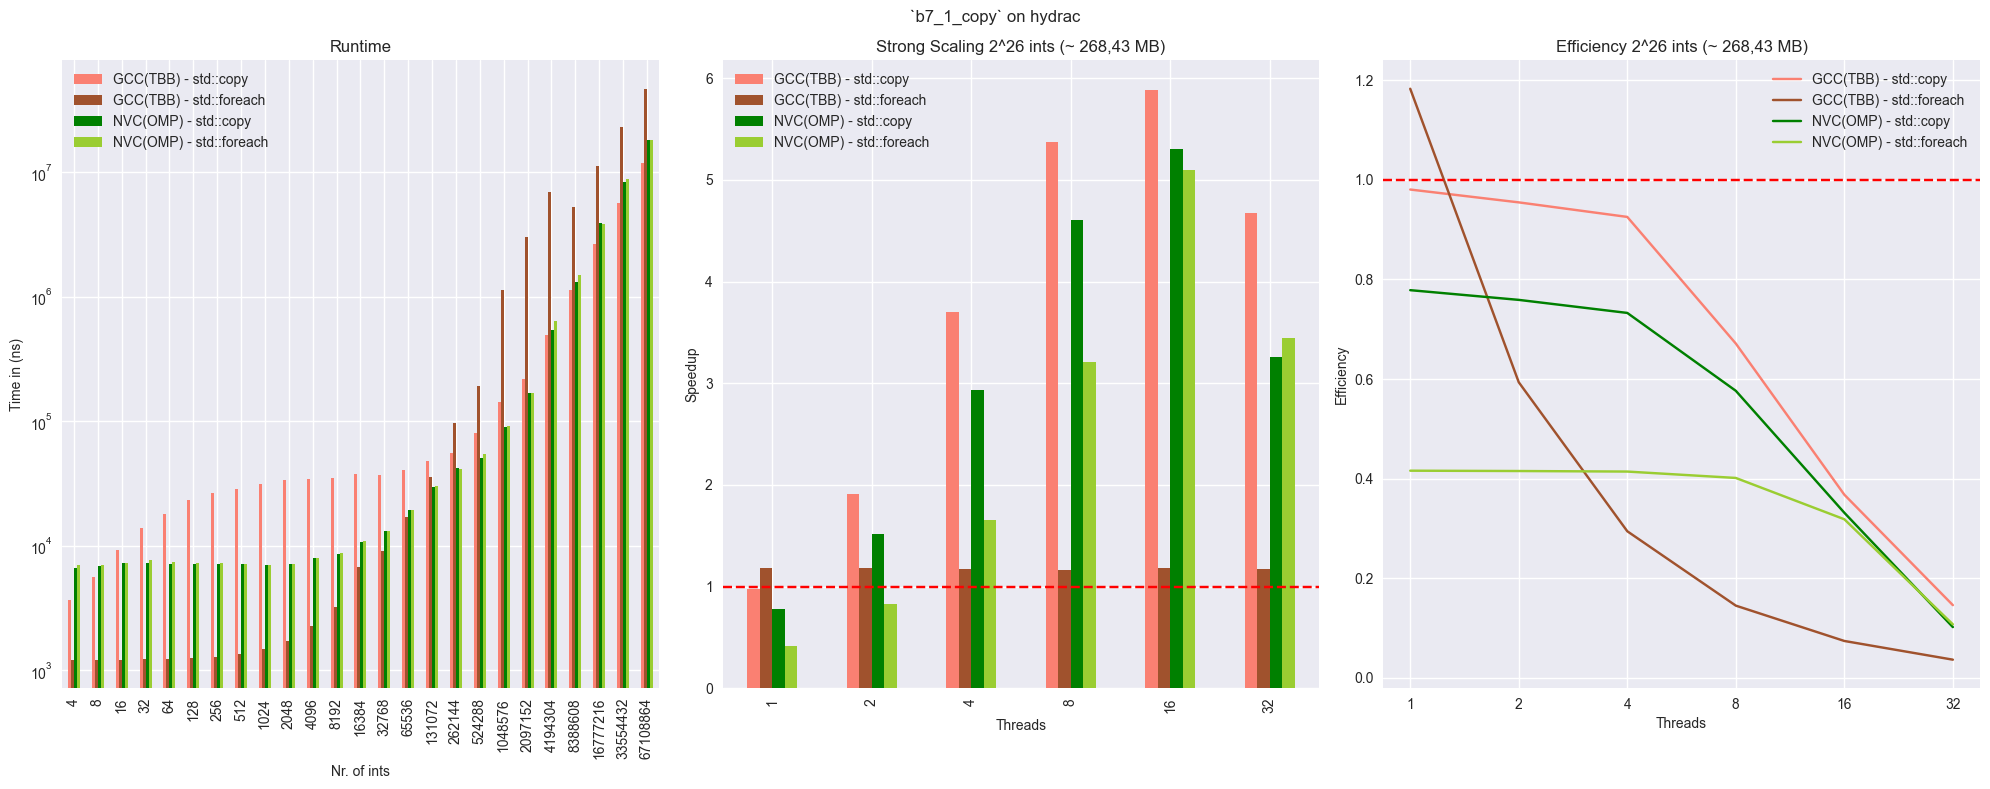

In [24]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_1_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_1_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,2.75)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b7_1_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

#ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_1_copy` on {device_name}")

fig.tight_layout()

plot(f"`b7_1_copy` {device_name}")

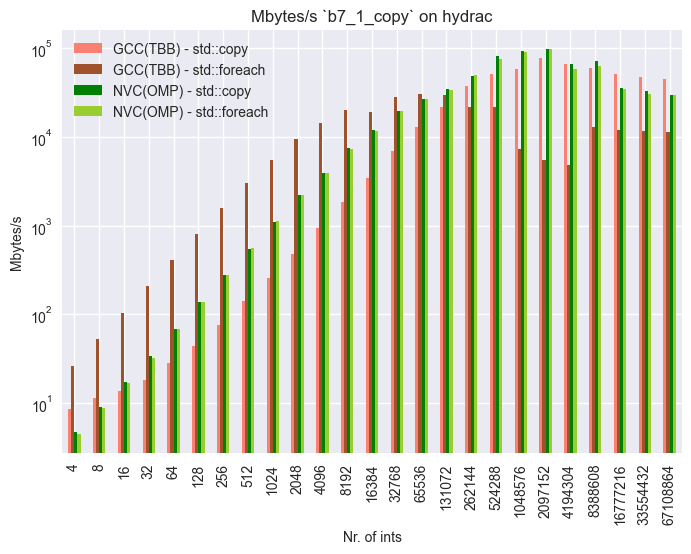

In [25]:
# mybtes graph


b7_1_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                    )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_1_copy` on {device_name}')


plot(f'`b7_1_copy` Mbytes_s on {device_name}')

## `b7_2` -  all_true

In [26]:
benchmark_names = [
    ("b7_2_all_of_all_true",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_all_true",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_all_true'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_true

Check how the runtime without constraining the threads develops with increasing input size

In [27]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_time_merged = pd.merge(b7_2_time_merged,data[i], on='n')

b7_2_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,3678.19,4,2922.16,27082.9,11391.6
1,5506.46,8,3822.29,24866.2,11515.2
2,8759.38,16,5758.96,25405.4,12687.7
3,13286.80,32,9310.03,27487.4,13656.5
4,17080.70,64,13900.80,26047.0,13842.1
5,20863.70,128,18276.60,25829.4,13516.1
6,24120.80,256,22873.60,26005.9,13677.8
7,26725.00,512,25641.30,25648.3,13856.5
8,29933.70,1024,28770.40,26370.7,13918.3
9,33458.10,2048,33526.40,26461.4,14377.5


### Strong Scaling - all true
 
2^26 fixed input size with threads 1-64

In [28]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_strong_scaling_merged = pd.merge(b7_2_strong_scaling_merged,data[i], on='threads')


b7_2_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.795992,0.822127,0.271948,0.681941
1,2,1.533684,1.607820,0.537079,1.335194
2,4,3.015308,3.103987,1.034986,2.297030
3,8,5.941412,5.999914,1.974934,4.923102
4,16,9.369119,9.230231,3.708969,9.236626
5,32,9.254399,9.785924,6.090908,10.558754


In [29]:
## efficiency graph

b7_2_efficiency = b7_2_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_efficiency[f'{compiler_name} - {display_name}'] = b7_2_efficiency[f'{compiler_name} - {display_name}'] / b7_2_efficiency['threads']

b7_2_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.795992,0.822127,0.271948,0.681941
1,2,0.766842,0.803910,0.268539,0.667597
2,4,0.753827,0.775997,0.258747,0.574257
3,8,0.742676,0.749989,0.246867,0.615388
4,16,0.585570,0.576889,0.231811,0.577289
5,32,0.289200,0.305810,0.190341,0.329961


### Mbytes/s

In [30]:
# collect data for instances

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  benchmark_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_all_true_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_all_true_bytes_merged = pd.merge(b7_2_all_true_bytes_merged,data[i], on='n')

b7_2_all_true_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,4.30975,10.8493,0.611192,2.76092
1,8,5.70715,16.5231,1.278960,5.48492
2,16,7.14233,22.0301,2.510780,9.97818
3,32,9.44129,27.1831,4.611570,18.54190
4,64,14.78900,36.4026,9.749780,36.58900
5,128,24.28890,55.5133,19.657800,74.94100
6,256,42.08700,88.9575,38.988000,148.18400
7,512,75.93730,158.9610,79.285300,292.38000
8,1024,135.71300,283.4420,153.630000,581.96300
9,2048,243.29200,486.5670,306.697000,1118.24000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_27218/3600482037.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


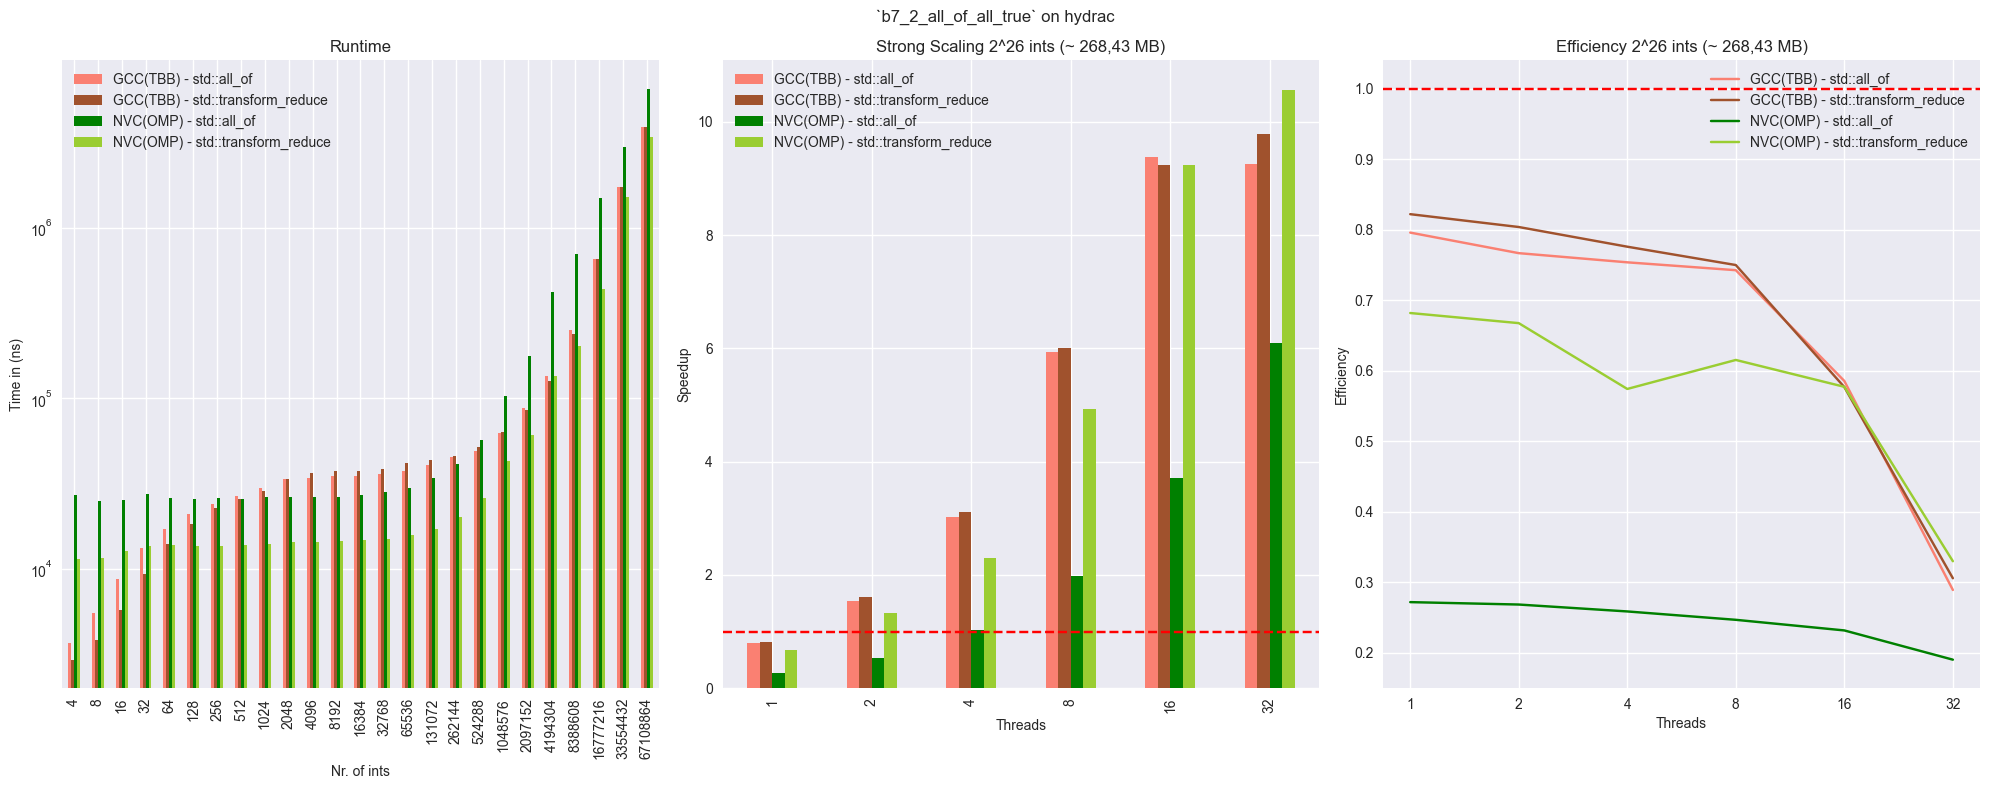

In [31]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
##ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

#ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_all_true` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_all_true` {device_name}")

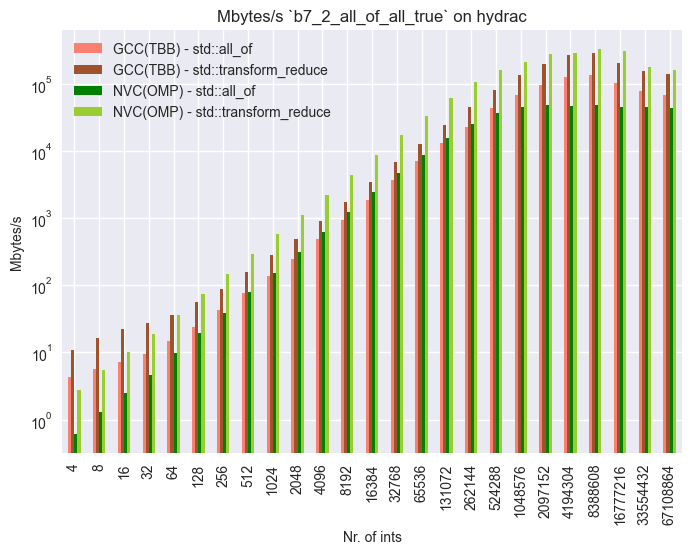

In [32]:
# mybtes graph


b7_2_all_true_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_all_true` on {device_name}')


plot(f'`b7_2_all_of_all_true` Mbytes_s on {device_name}')

## `b7_2` -  first_false

In [33]:
benchmark_names = [
    ("b7_2_all_of_first_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_first_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_first_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - first_false

Check how the runtime without constraining the threads develops with increasing input size

In [34]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_first_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_time_merged = pd.merge(b7_2_first_false_time_merged,data[i], on='n')

b7_2_first_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,3388.37,4,2958.40,24159.3,11697.4
1,4056.00,8,3764.05,25282.5,11955.5
2,4809.59,16,5714.63,25549.4,12943.2
3,5847.52,32,9237.41,25421.9,13994.3
4,6766.89,64,13875.20,25262.8,14074.9
5,8029.00,128,17741.30,24756.4,14662.2
6,8499.68,256,22475.30,24579.6,14126.5
7,8504.23,512,26692.70,24514.9,14105.2
8,8522.38,1024,29910.50,26472.3,14227.3
9,8539.16,2048,33477.80,26549.7,14051.9


### Strong Scaling - first_false
 
2^26 fixed input size with threads 1-64

In [35]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_first_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_strong_scaling_merged = pd.merge(b7_2_first_false_strong_scaling_merged,data[i], on='threads')


b7_2_first_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.553063,0.000031,0.000481,0.000012
1,2,0.297042,0.000060,0.000949,0.000024
2,4,0.240844,0.000117,0.001852,0.000048
3,8,0.167339,0.000236,0.003548,0.000092
4,16,0.187669,0.000326,0.006309,0.000171
5,32,0.112597,0.000337,0.010290,0.000300


In [36]:
## efficiency graph

b7_2_first_false_efficiency = b7_2_first_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_first_false_efficiency['threads']

b7_2_first_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.553063,0.000031,0.000481,0.000012
1,2,0.148521,0.000030,0.000474,0.000012
2,4,0.060211,0.000029,0.000463,0.000012
3,8,0.020917,0.000029,0.000444,0.000012
4,16,0.011729,0.000020,0.000394,0.000011
5,32,0.003519,0.000011,0.000322,0.000009


### Mbytes/s

In [37]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_first_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_bytes_merged = pd.merge(b7_2_first_false_bytes_merged,data[i], on='n')

b7_2_first_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,4.678070e+00,10.7309,6.609800e-01,2.72205
1,8,7.812330e+00,16.8302,1.272180e+00,5.30254
2,16,1.319550e+01,22.1694,2.497070e+00,9.70562
3,32,2.172600e+01,27.4210,5.016900e+00,18.01470
4,64,3.756000e+01,36.5895,1.011630e+01,35.80720
5,128,6.327320e+01,57.3666,2.064100e+01,69.12440
6,256,1.196100e+02,90.4640,4.159560e+01,142.50700
7,512,2.392320e+02,152.4850,8.332240e+01,285.54100
8,1024,4.771870e+02,272.4570,1.545200e+02,567.72300
9,2048,9.521490e+02,487.1750,3.080570e+02,1148.85000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_27218/1392981099.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


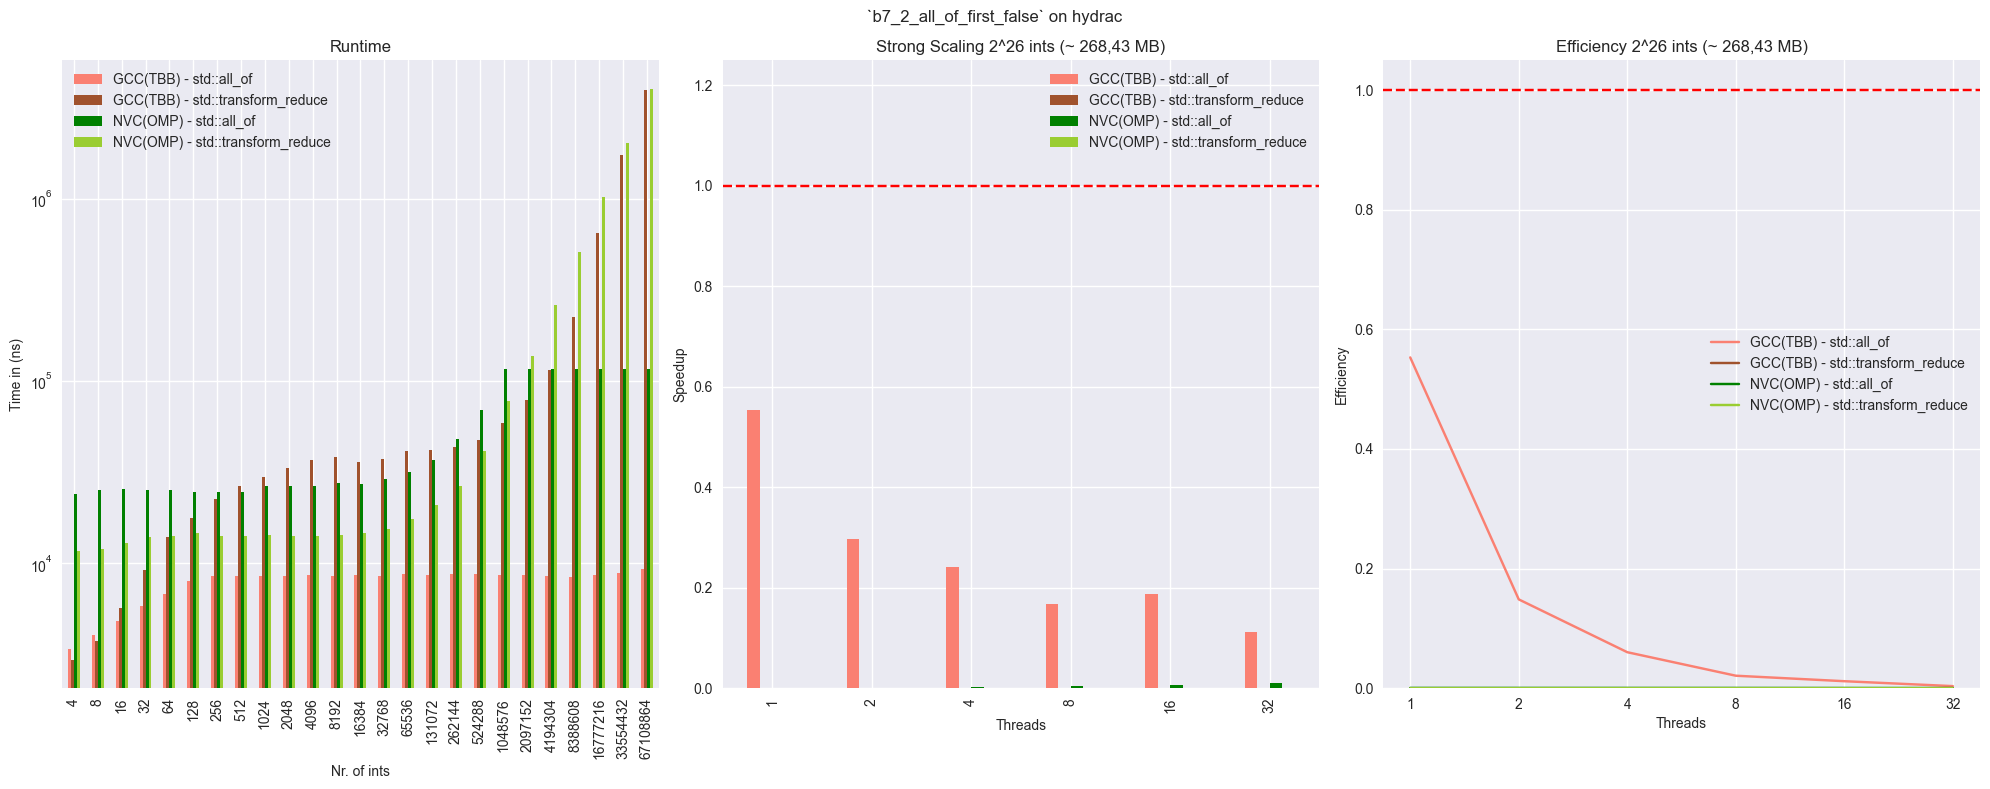

In [38]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_first_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_first_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
ax_2.set_ylim(0,1.25)





# plot efficiency
ax_3 = b7_2_first_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_first_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_first_false` {device_name}")

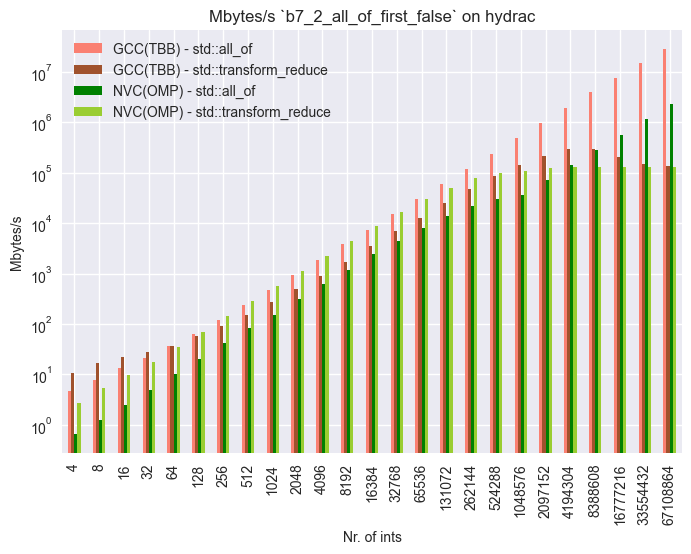

In [39]:

# mybtes graph


b7_2_first_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_first_false` on {device_name}')


plot(f'`b7_2_all_of_first_false` Mbytes_s on {device_name}')

## `b7_2` -  last_false

In [40]:
benchmark_names = [
    ("b7_2_all_of_last_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_last_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_last_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - last_false

Check how the runtime without constraining the threads develops with increasing input size

In [41]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_last_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_time_merged = pd.merge(b7_2_last_false_time_merged,data[i], on='n')

b7_2_last_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,3809.21,4,2942.99,24461.9,11381.3
1,5608.16,8,3846.54,24505.0,12786.0
2,8837.97,16,5962.06,24867.7,12872.2
3,12988.90,32,9226.43,25410.1,13868.7
4,17409.80,64,13811.00,25376.6,13922.2
5,20917.70,128,17798.40,25356.2,14096.5
6,22512.10,256,22317.00,25388.1,14182.1
7,24881.40,512,25571.90,25557.2,13468.0
8,26923.50,1024,29365.30,25757.2,12886.3
9,29306.70,2048,32458.90,25819.2,14214.2


### Strong Scaling - last_false
 
2^26 fixed input size with threads 1-64

In [42]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_last_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_strong_scaling_merged = pd.merge(b7_2_last_false_strong_scaling_merged,data[i], on='threads')


b7_2_last_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.904056,0.927100,0.242722,0.400162
1,2,1.719324,1.837106,0.480554,0.803216
2,4,3.478563,3.502207,0.934091,1.563758
3,8,6.216424,7.103798,1.809924,3.194266
4,16,12.415560,11.629589,3.339658,6.238170
5,32,12.253458,10.435625,3.853325,10.658726


In [43]:
## efficiency graph

b7_2_last_false_efficiency = b7_2_last_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_last_false_efficiency['threads']

b7_2_last_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.904056,0.927100,0.242722,0.400162
1,2,0.859662,0.918553,0.240277,0.401608
2,4,0.869641,0.875552,0.233523,0.390940
3,8,0.777053,0.887975,0.226241,0.399283
4,16,0.775973,0.726849,0.208729,0.389886
5,32,0.382921,0.326113,0.120416,0.333085


### Mbytes/s

In [44]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_last_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_bytes_merged = pd.merge(b7_2_last_false_bytes_merged,data[i], on='n')

b7_2_last_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,4.14218,10.7884,0.644806,2.78124
1,8,5.61946,16.4971,1.285200,4.95581
2,16,7.16964,21.2778,2.536610,9.83571
3,32,9.75478,27.5170,4.966300,18.24040
4,64,14.55380,36.8132,9.950240,36.35160
5,128,24.29040,57.1038,19.920200,71.99070
6,256,45.18880,91.1430,39.874300,143.29700
7,512,81.81640,159.2480,79.194900,301.03600
8,1024,151.31100,277.5440,157.074000,628.41400
9,2048,278.11600,501.8720,313.514000,1153.80000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_27218/3655766821.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


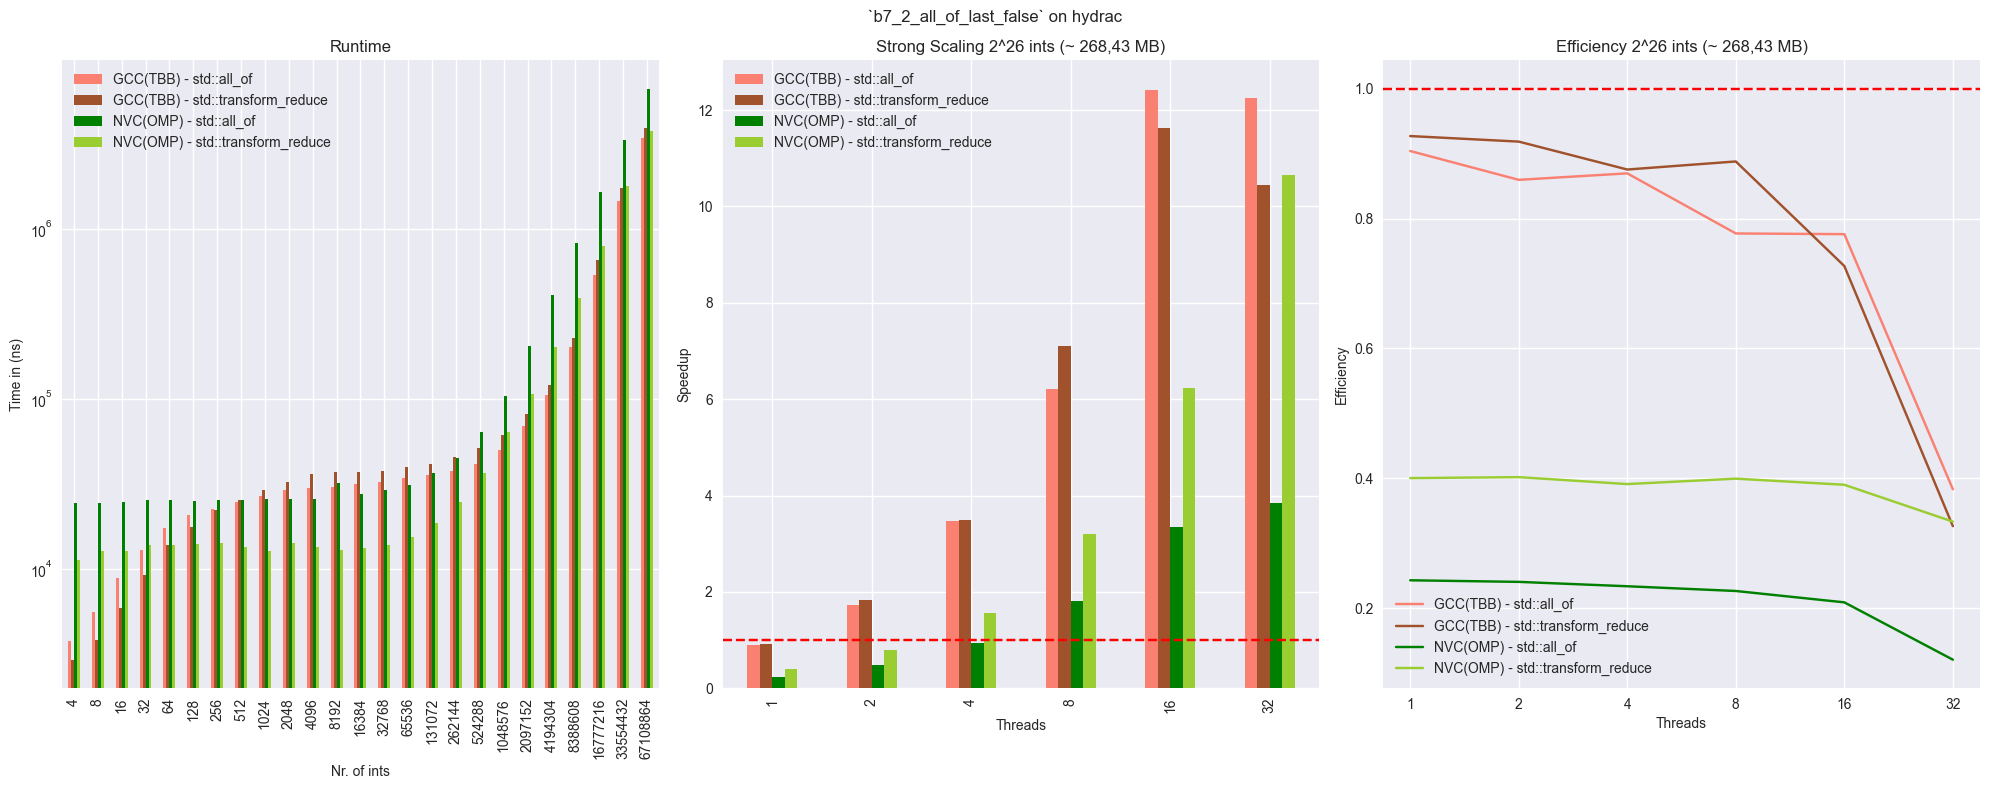

In [45]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_last_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_last_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
#ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_last_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

#ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_last_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_last_false` {device_name}")

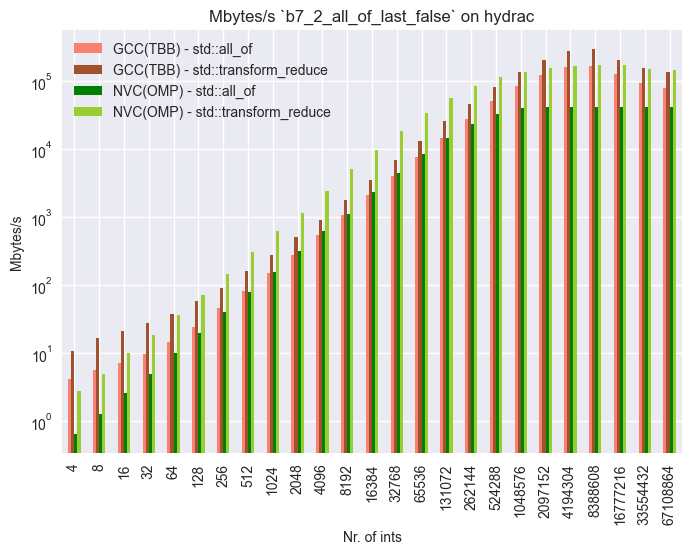

In [46]:
b7_2_last_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_last_false` on {device_name}')


plot(f'`b7_2_all_of_last_false` Mbytes_s on {device_name}')

## `b7_2` -  auto_false

In [47]:
benchmark_names = [
    ("b7_2_all_of_auto_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_auto_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_auto_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - auto_false

Check how the runtime without constraining the threads develops with increasing input size

In [48]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_auto_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_time_merged = pd.merge(b7_2_auto_false_time_merged,data[i], on='n')

b7_2_auto_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,3390.88,4,2971.82,26969.9,12159.0
1,4012.06,8,3859.94,26292.5,12699.0
2,4884.36,16,5735.25,25920.7,12765.4
3,5693.62,32,9193.22,26727.9,14007.2
4,6994.04,64,13888.40,26336.6,13897.1
5,7755.02,128,18204.00,26538.4,13771.5
6,7920.13,256,21850.50,26461.4,13950.9
7,8018.69,512,26180.50,26467.7,14192.2
8,7912.17,1024,27452.00,26443.6,14108.2
9,8118.87,2048,31037.30,26491.9,14128.6


### Strong Scaling - auto_false
 
2^26 fixed input size with threads 1-64

In [49]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_auto_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_strong_scaling_merged = pd.merge(b7_2_auto_false_strong_scaling_merged,data[i], on='threads')


b7_2_auto_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.553801,0.000077,0.009464,0.628871
1,2,0.310692,0.000154,0.016846,0.245871
2,4,0.313359,0.000306,0.029364,0.223305
3,8,0.156855,0.000604,0.038610,0.167030
4,16,0.215144,0.001174,0.040743,0.100799
5,32,0.161177,0.002184,0.046258,0.092180


In [50]:
## efficiency graph

b7_2_auto_false_efficiency = b7_2_auto_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_auto_false_efficiency['threads']

b7_2_auto_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.553801,0.000077,0.009464,0.628871
1,2,0.155346,0.000077,0.008423,0.122936
2,4,0.078340,0.000077,0.007341,0.055826
3,8,0.019607,0.000076,0.004826,0.020879
4,16,0.013446,0.000073,0.002546,0.006300
5,32,0.005037,0.000068,0.001446,0.002881


### Mbytes/s

In [51]:
# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_auto_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_bytes_merged = pd.merge(b7_2_auto_false_bytes_merged,data[i], on='n')

b7_2_auto_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,4.669810e+00,10.6652,5.913030e-01,2.607740e+00
1,8,7.895270e+00,16.3909,1.214750e+00,4.993500e+00
2,16,1.298400e+01,22.1072,2.462380e+00,9.945960e+00
3,32,2.224280e+01,27.4200,4.793570e+00,1.810960e+01
4,64,3.624010e+01,36.4169,9.699560e+00,3.652410e+01
5,128,6.522220e+01,55.7306,1.924310e+01,7.371670e+01
6,256,1.279280e+02,93.0239,3.859780e+01,1.454820e+02
7,512,2.527320e+02,155.3910,7.719340e+01,2.861590e+02
8,1024,5.111770e+02,296.9890,1.545400e+02,5.757590e+02
9,2048,9.982190e+02,525.5670,3.084530e+02,1.149520e+03


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_27218/1629545763.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


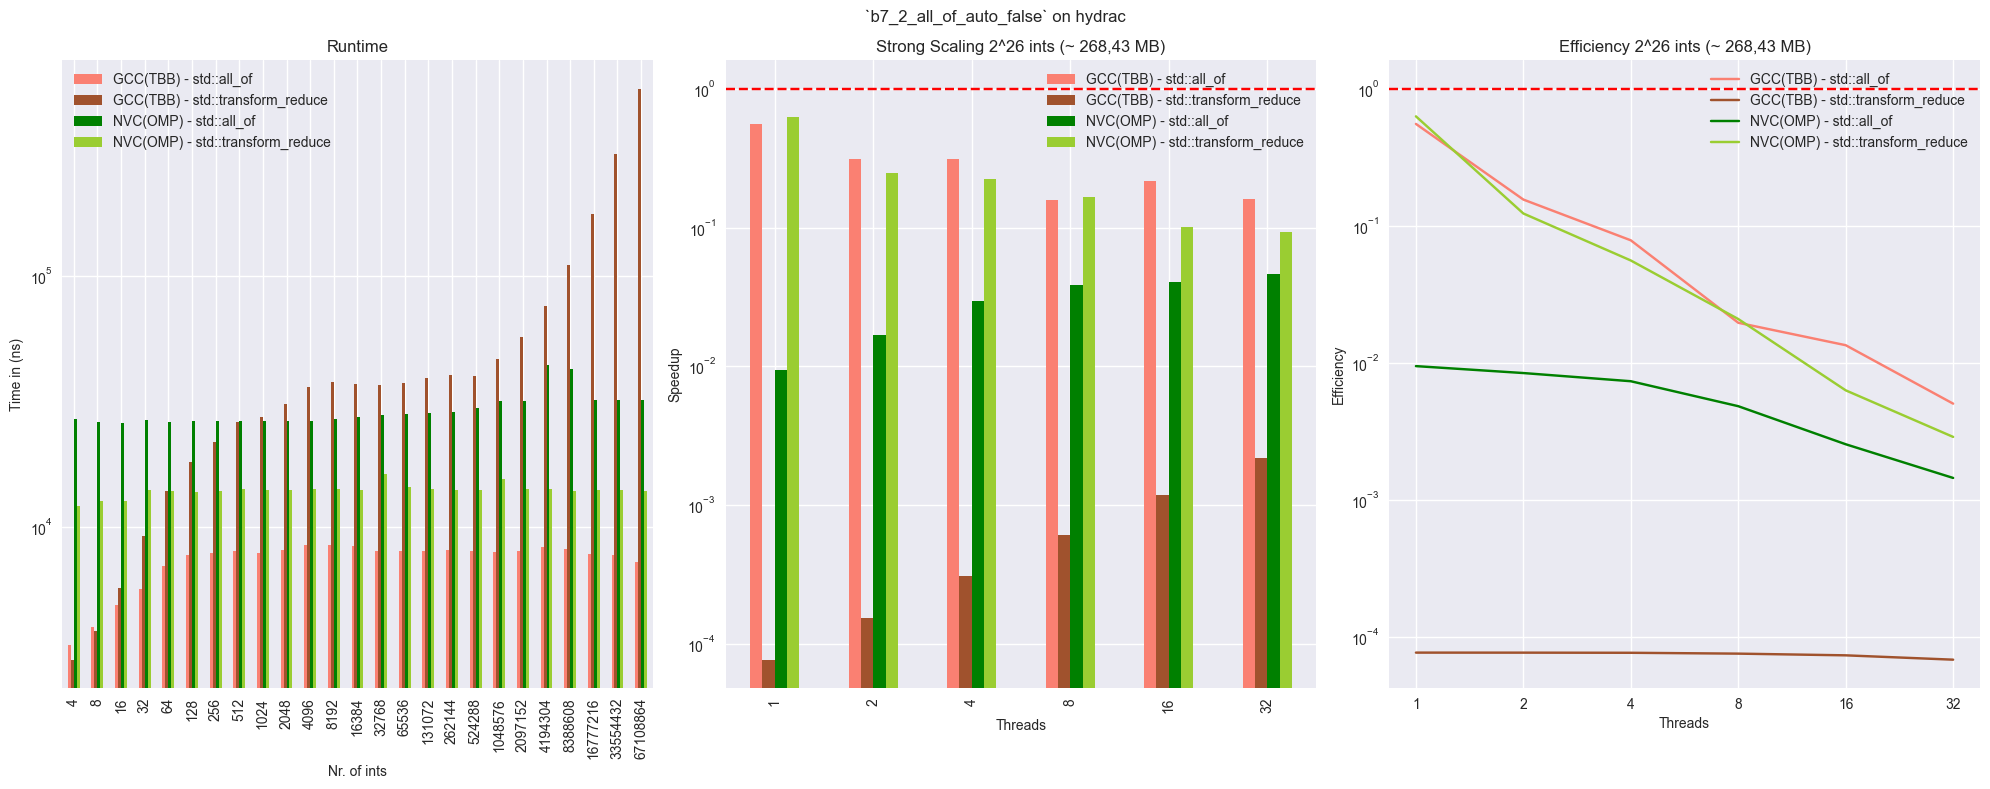

In [52]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_auto_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_auto_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_yscale('log',base=10)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')



# plot efficiency
ax_3 = b7_2_auto_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_yscale('log',base=10)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_auto_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_auto_false` {device_name}")

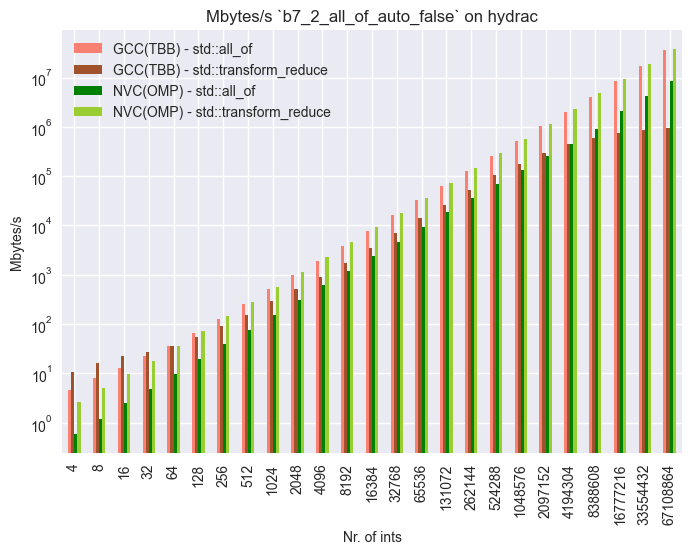

In [53]:

# mybtes graph

b7_2_auto_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_auto_false` on {device_name}')


plot(f'`b7_2_all_of_auto_false` Mbytes_s on {device_name}')

## `b7_3` -  all_hit

In [54]:
benchmark_names = [
    ("b7_3_count_if_all_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_all_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_all_hit",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_all_hit'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_hit

Check how the runtime without constraining the threads develops with increasing input size

In [55]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_all_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_time_merged = pd.merge(b7_3_all_hit_time_merged,data[i], on='n')

b7_3_all_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,3885.54,4,2926.24,11974.5,11653.3
1,5918.60,8,3798.52,12822.0,12178.4
2,9696.71,16,5766.55,13033.4,12254.2
3,14483.40,32,9079.20,13448.0,13507.2
4,18627.00,64,14019.90,13390.1,14114.4
5,23641.10,128,18563.60,13407.0,13439.2
6,27922.00,256,22488.70,13392.9,14484.5
7,31031.40,512,26304.90,13365.0,14193.4
8,34920.20,1024,30188.40,13183.5,14248.5
9,39391.90,2048,33000.60,13078.6,14267.8


### Strong Scaling - all_hit
 
2^26 fixed input size with threads 1-64

In [56]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_all_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_strong_scaling_merged = pd.merge(b7_3_all_hit_strong_scaling_merged,data[i], on='threads')


b7_3_all_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.997573,0.754463,1.449455,1.523696
1,2,1.906301,1.457100,2.790994,2.890285
2,4,3.489717,2.743453,5.254641,5.762684
3,8,6.788962,4.727160,7.529373,6.754024
4,16,9.001909,7.961150,13.928690,12.481105
5,32,8.998092,8.976134,10.632635,10.703835


In [57]:
## efficiency graph

b7_3_all_hit_efficiency = b7_3_all_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_all_hit_efficiency['threads']

b7_3_all_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.997573,0.754463,1.449455,1.523696
1,2,0.953150,0.728550,1.395497,1.445143
2,4,0.872429,0.685863,1.313660,1.440671
3,8,0.848620,0.590895,0.941172,0.844253
4,16,0.562619,0.497572,0.870543,0.780069
5,32,0.281190,0.280504,0.332270,0.334495


### Mbytes/s

In [58]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_all_hit_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_bytes_merged = pd.merge(b7_3_all_hit_bytes_merged,data[i], on='n')

b7_3_all_hit_bytes_merged

,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,4.07958,5.40781,1.32001,1.35668
1,8,5.35598,8.30964,2.43506,2.59340
2,16,6.52463,10.93270,4.80019,5.11767
3,32,8.75548,13.78960,9.29569,9.29690
4,64,13.64160,17.99950,18.64990,17.88580
5,128,21.53210,27.30290,37.30170,37.63730
6,256,36.51180,45.10720,74.73190,71.71510
7,512,65.70470,77.19940,150.45300,143.20600
8,1024,116.84400,134.73200,309.06300,284.98200
9,2048,207.39500,246.67500,622.99700,569.09900


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_27218/3164471847.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


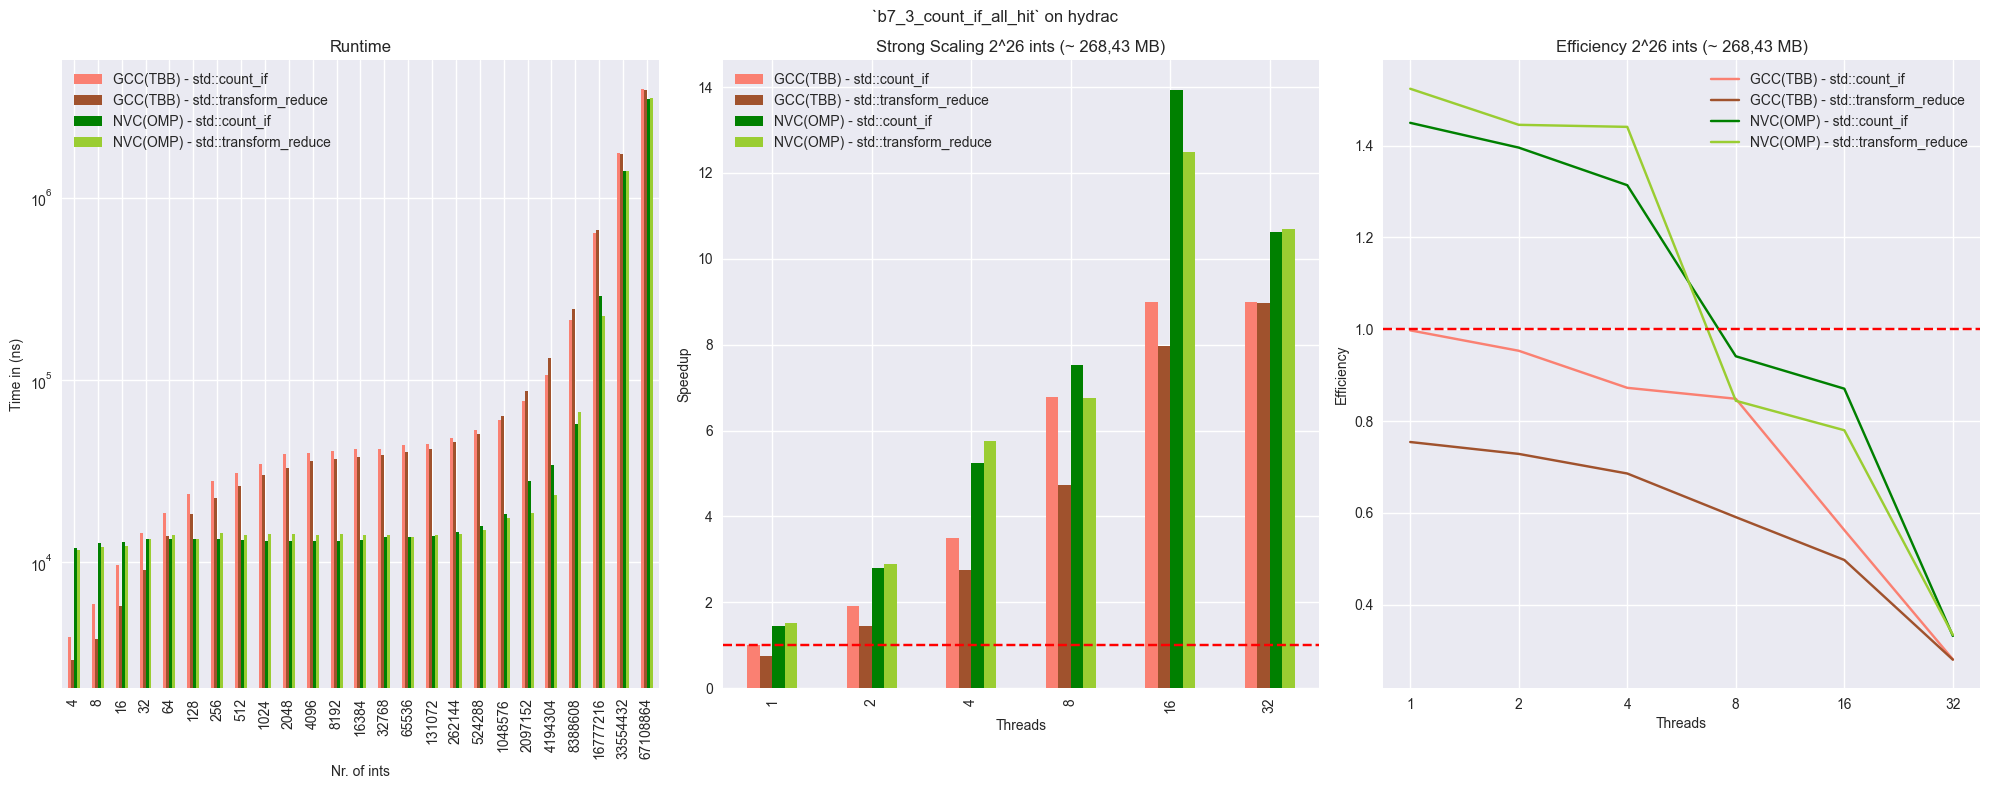

In [59]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_all_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_all_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_all_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')

fig.suptitle(f"`b7_3_count_if_all_hit` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_all_hit` {device_name}")

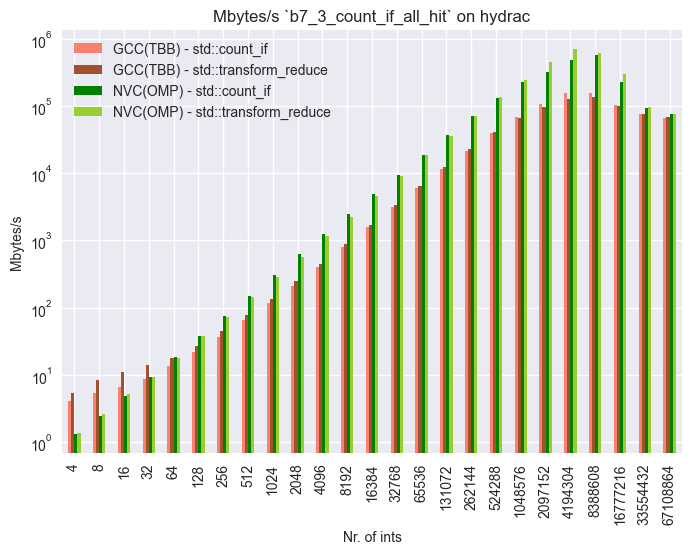

In [60]:
# mybtes graph

b7_3_all_hit_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_3_count_if_all_hit` on {device_name}')


plot(f'`b7_3_count_if_all_hit` Mbytes_s on {device_name}')

## `b7_3` -  half_hit

In [61]:
benchmark_names = [
    ("b7_3_count_if_half_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_half_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_half_hit",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_half_hit'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - half_hit

Check how the runtime without constraining the threads develops with increasing input size

In [62]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_half_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_time_merged = pd.merge(b7_3_half_hit_time_merged,data[i], on='n')

b7_3_half_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,3889.58,4,3033.53,11586.1,12848.3
1,6071.35,8,3952.39,12140.7,13115.6
2,10142.80,16,5840.53,12738.3,13147.6
3,15167.40,32,9416.34,13471.2,14856.6
4,19606.60,64,14480.60,13589.6,13880.3
5,24370.00,128,17707.40,13599.9,13963.4
6,28890.70,256,22994.10,13803.1,13813.4
7,33523.70,512,26666.30,14756.9,13775.7
8,39411.30,1024,29944.20,15161.5,13487.5
9,45882.70,2048,33988.90,15142.4,13509.3


### Strong Scaling - half_hit
 
2^26 fixed input size with threads 1-64

In [63]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_half_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_strong_scaling_merged = pd.merge(b7_3_half_hit_strong_scaling_merged,data[i], on='threads')


b7_3_half_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.749068,0.537589,1.134078,1.160692
1,2,1.517209,1.100993,1.995720,2.192496
2,4,2.613478,2.159543,4.053311,3.198904
3,8,5.393945,4.205800,5.593202,7.784742
4,16,7.054416,6.040807,8.109350,10.540532
5,32,6.807573,6.861823,7.808429,7.890975


In [64]:
## efficiency graph

b7_3_half_hit_efficiency = b7_3_half_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_half_hit_efficiency['threads']

b7_3_half_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.749068,0.537589,1.134078,1.160692
1,2,0.758605,0.550497,0.997860,1.096248
2,4,0.653370,0.539886,1.013328,0.799726
3,8,0.674243,0.525725,0.699150,0.973093
4,16,0.440901,0.377550,0.506834,0.658783
5,32,0.212737,0.214432,0.244013,0.246593


### Mybtes/s

In [65]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_half_hit_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_bytes_merged = pd.merge(b7_3_half_hit_bytes_merged,data[i], on='n')

b7_3_half_hit_bytes_merged


,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,4.08804,5.23312,1.37471,1.25272
1,8,5.23247,8.03593,2.62411,2.41874
2,16,6.25796,10.84140,5.00723,4.80223
3,32,8.37409,13.44860,9.41377,8.58715
4,64,12.95680,17.46630,18.55300,18.13930
5,128,20.91600,28.65210,37.32580,36.13050
6,256,35.25450,44.15000,73.97230,72.92430
7,512,60.81930,76.24920,139.40800,146.18700
8,1024,103.53500,135.97800,270.08700,298.76500
9,2048,177.87000,239.58900,540.72000,596.31800


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_27218/4180608575.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


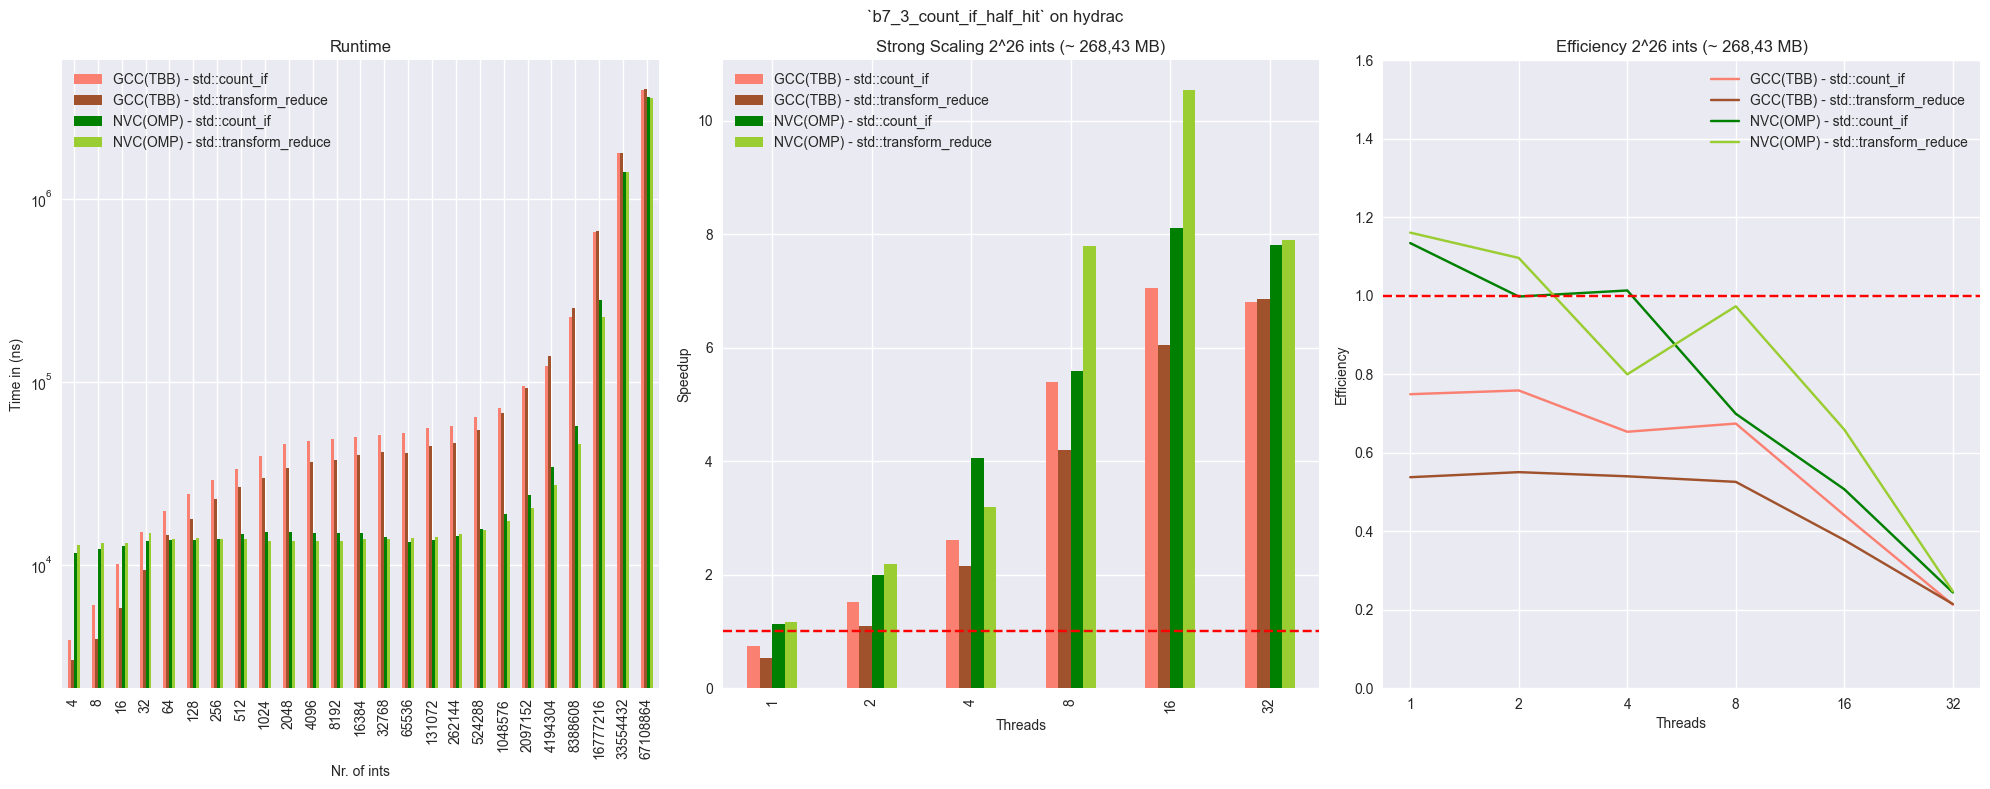

In [66]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_half_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_half_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_half_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')
ax_3.set_ylim(0,1.6)


fig.suptitle(f"`b7_3_count_if_half_hit` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_half_hit` {device_name}")

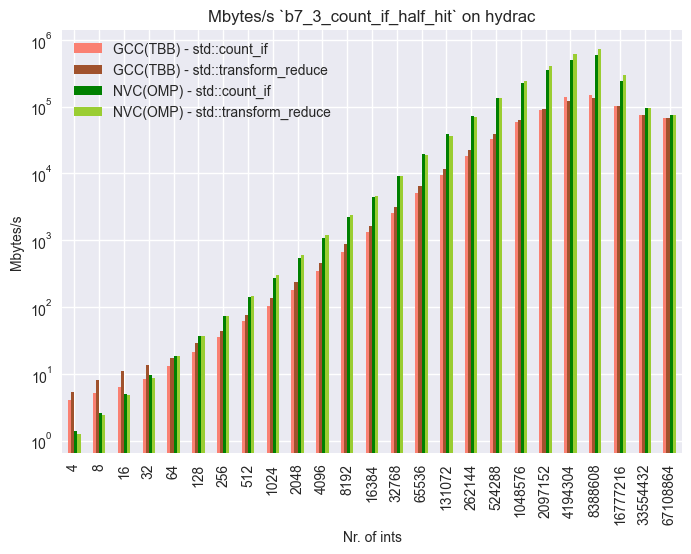

In [67]:
# mybtes graph

b7_3_half_hit_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_3_count_if_half_hit` on {device_name}')


plot(f'`b7_3_count_if_half_hit` Mbytes_s on {device_name}')

## `b7_3` -  orders_struct

In [68]:
benchmark_names = [
    ("b7_3_count_if_orders_struct",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_orders_struct",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_orders_struct",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_orders_struct'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - orders_struct

Check how the runtime without constraining the threads develops with increasing input size

In [69]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_orders_struct_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_time_merged = pd.merge(b7_3_orders_struct_time_merged,data[i], on='n')

b7_3_orders_struct_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,3808.62,4,2937.10,11929.9,11472.4
1,5852.24,8,3836.93,12733.0,11862.3
2,9597.13,16,5738.93,13624.5,11803.2
3,14385.70,32,9176.10,13729.5,13213.6
4,18026.80,64,13616.20,14054.2,13120.6
5,22075.80,128,17431.30,15384.1,13356.7
6,26252.50,256,20880.70,14039.3,13316.1
7,29879.30,512,25570.70,14026.2,13382.3
8,32275.10,1024,29719.70,14517.6,13417.8
9,36233.20,2048,33836.60,14019.2,13409.1


### Strong Scaling - orders_struct
 
2^26 fixed input size with threads 1-64

In [70]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_orders_struct_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_strong_scaling_merged = pd.merge(b7_3_orders_struct_strong_scaling_merged,data[i], on='threads')


b7_3_orders_struct_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.063207,1.012148,1.452742,1.627645
1,2,1.959526,1.870749,2.821145,3.157532
2,4,4.032764,3.876562,5.274377,4.385075
3,8,7.382401,7.864397,5.745947,11.223730
4,16,10.181726,10.168379,13.143109,14.401968
5,32,9.398104,9.736366,10.492669,10.498948


In [71]:
## efficiency graph

b7_3_orders_struct_efficiency = b7_3_orders_struct_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] = b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] / b7_3_orders_struct_efficiency['threads']

b7_3_orders_struct_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.063207,1.012148,1.452742,1.627645
1,2,0.979763,0.935375,1.410573,1.578766
2,4,1.008191,0.969141,1.318594,1.096269
3,8,0.922800,0.983050,0.718243,1.402966
4,16,0.636358,0.635524,0.821444,0.900123
5,32,0.293691,0.304261,0.327896,0.328092


### Mbytes/s

In [72]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_orders_struct_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_bytes_merged = pd.merge(b7_3_orders_struct_bytes_merged,data[i], on='n')

b7_3_orders_struct_bytes_merged

,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,8.3012,10.8055,2.66649,2.77802
1,8,10.8137,16.4959,4.99969,5.37521
2,16,13.1062,21.9937,9.32923,10.81430
3,32,17.5914,27.5313,18.44140,19.29270
4,64,28.0986,37.1831,36.19820,38.78970
5,128,46.0250,58.3023,68.72530,75.00630
6,256,77.5269,97.4766,144.74600,150.62000
7,512,136.4500,159.2690,289.48400,299.45300
8,1024,252.6210,274.2130,562.19400,597.69500
9,2048,450.5350,482.0630,1159.02000,1197.13000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_27218/2492568009.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


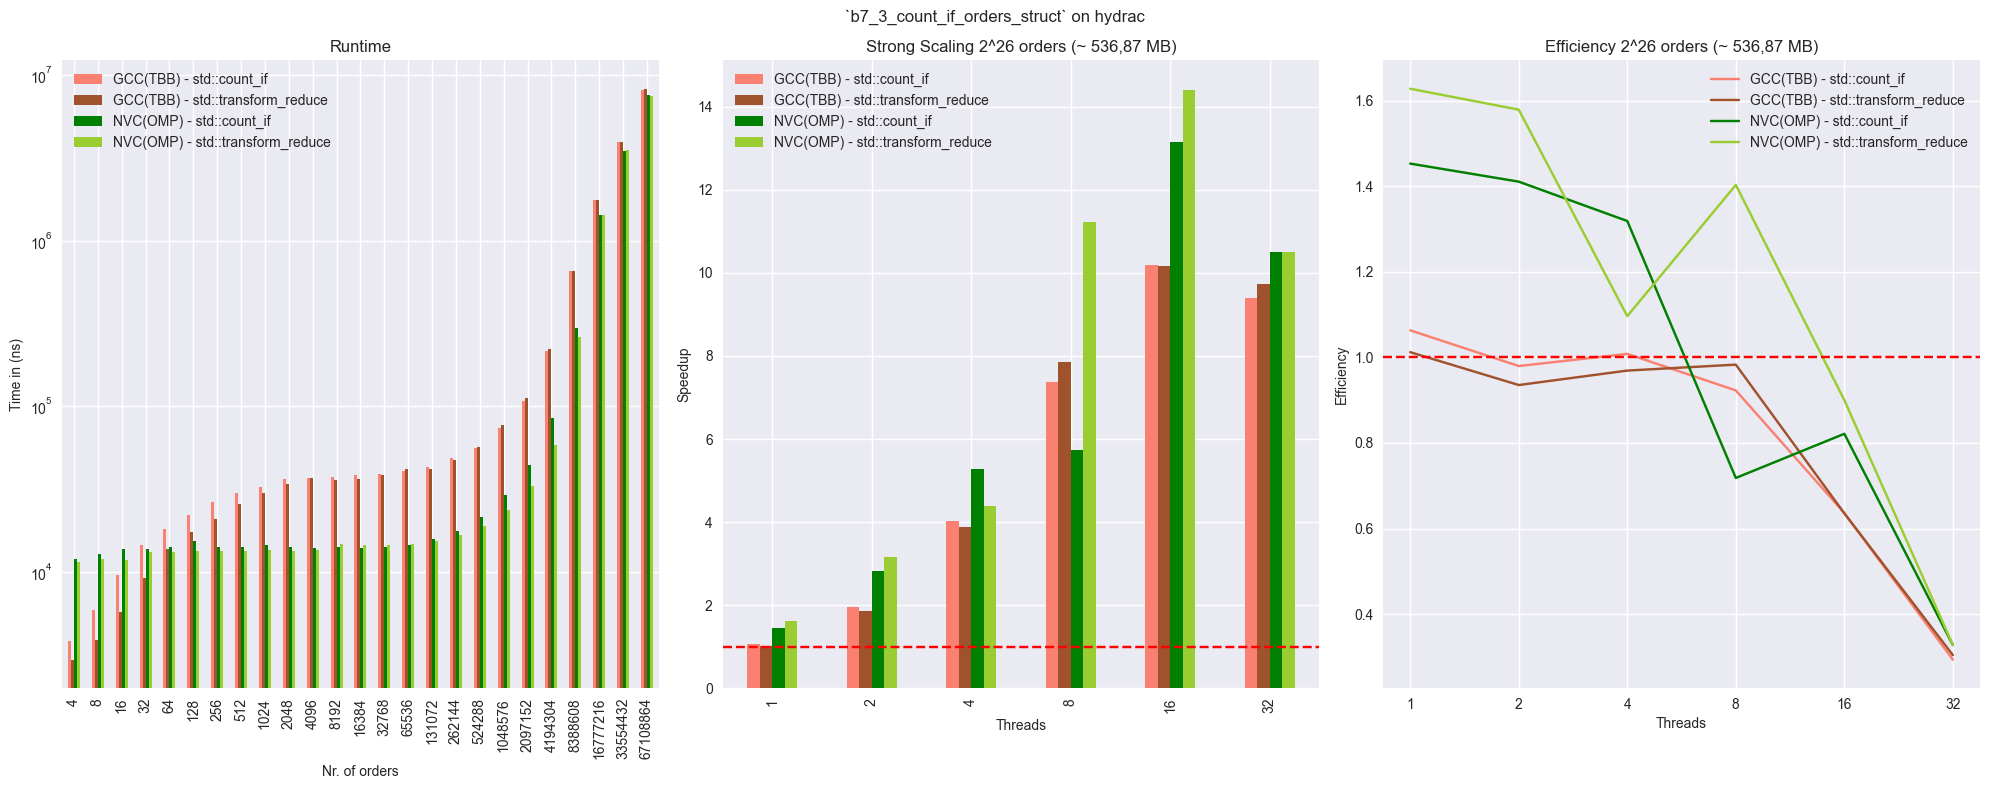

In [73]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_orders_struct_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of orders')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_orders_struct_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 orders (~ 536,87 MB)')





# plot efficiency
ax_3 = b7_3_orders_struct_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 orders (~ 536,87 MB)')


fig.suptitle(f"`b7_3_count_if_orders_struct` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_orders_struct` {device_name}")

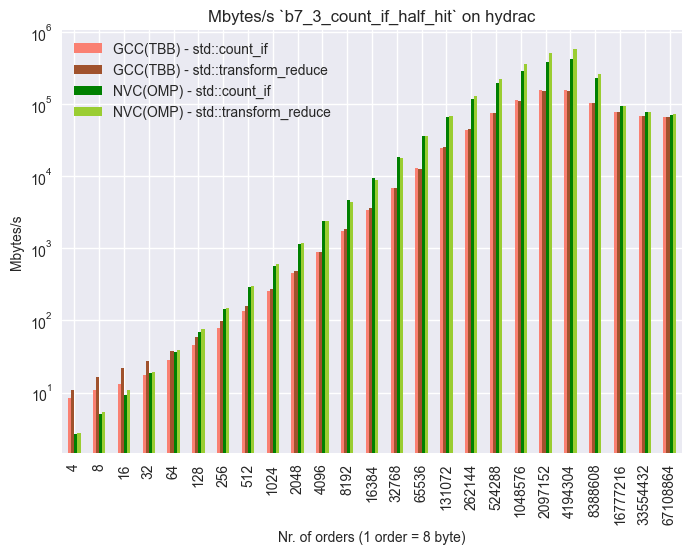

In [74]:
# mybtes graph

b7_3_orders_struct_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of orders (1 order = 8 byte)')
plt.title(f'Mbytes/s `b7_3_count_if_half_hit` on {device_name}')


plot(f'`b7_3_count_if_orders_struct` Mbytes_s on {device_name}')

## `b7_4` - stencil transform 

In [75]:
benchmark_names = [
    ("b7_4_stencil_transform_number_to_neightbours_stdev",'std::transform'),
    ("b7_4_stencil_for_each_to_neightbours_stdev",'std::for_each')
]

strong_scale_base = 'b7_4_stencil_transform_number_to_neightbours_stdev'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [76]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_4_stencil_time_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_time_merged = pd.merge(b7_4_stencil_time_merged,data[i], on='n')

b7_4_stencil_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,2969.96,4,3001.32,6802.03,6882.38
1,4996.45,8,5071.71,6812.80,7060.66
2,9059.82,16,8999.49,6820.68,7131.24
3,13898.40,32,14012.20,6969.81,7477.44
4,17961.60,64,19310.20,7061.44,7632.24
5,22698.30,128,22836.00,7199.60,7688.36
6,26105.60,256,25939.10,7205.64,7839.31
7,29288.20,512,29296.00,7161.16,8013.55
8,33626.80,1024,31336.10,7176.39,7932.89
9,36260.90,2048,35282.50,7221.78,7958.85


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [77]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_4_stencil_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_strong_scaling_merged = pd.merge(b7_4_stencil_strong_scaling_merged,data[i], on='threads')


b7_4_stencil_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.165053,0.163911,1.227846,0.687498
1,2,0.329937,0.327701,2.558904,1.346827
2,4,0.659915,0.655343,3.798185,2.606227
3,8,1.318618,1.302650,4.428253,3.545064
4,16,2.553995,2.524919,4.194754,3.891953
5,32,2.227749,2.263964,3.304699,2.837015


In [78]:
## efficiency graph

b7_4_stencil_efficiency = b7_4_stencil_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] = b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] / b7_4_stencil_efficiency['threads']

b7_4_stencil_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.165053,0.163911,1.227846,0.687498
1,2,0.164968,0.163850,1.279452,0.673413
2,4,0.164979,0.163836,0.949546,0.651557
3,8,0.164827,0.162831,0.553532,0.443133
4,16,0.159625,0.157807,0.262172,0.243247
5,32,0.069617,0.070749,0.103272,0.088657


### Mbytes/s

In [79]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_4_stencil_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_bytes_merged = pd.merge(b7_4_stencil_bytes_merged,data[i], on='n')

b7_4_stencil_bytes_merged


,n,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4,19.9587,19.8256,8.45528,8.4435
1,8,24.3894,24.2313,17.46900,16.9447
2,16,27.3285,27.6254,35.39540,34.0321
3,32,36.0801,35.8044,69.42790,65.7660
4,64,56.2340,52.3876,139.17400,129.3960
5,128,89.4345,88.8208,275.64500,257.2870
6,256,155.8100,156.7380,551.47600,506.7820
7,512,278.4940,278.1220,1109.89000,992.5150
8,1024,484.5370,520.4940,2208.53000,2001.2900
9,2048,899.7500,925.3660,4407.66000,3986.1600


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_27218/1698835649.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


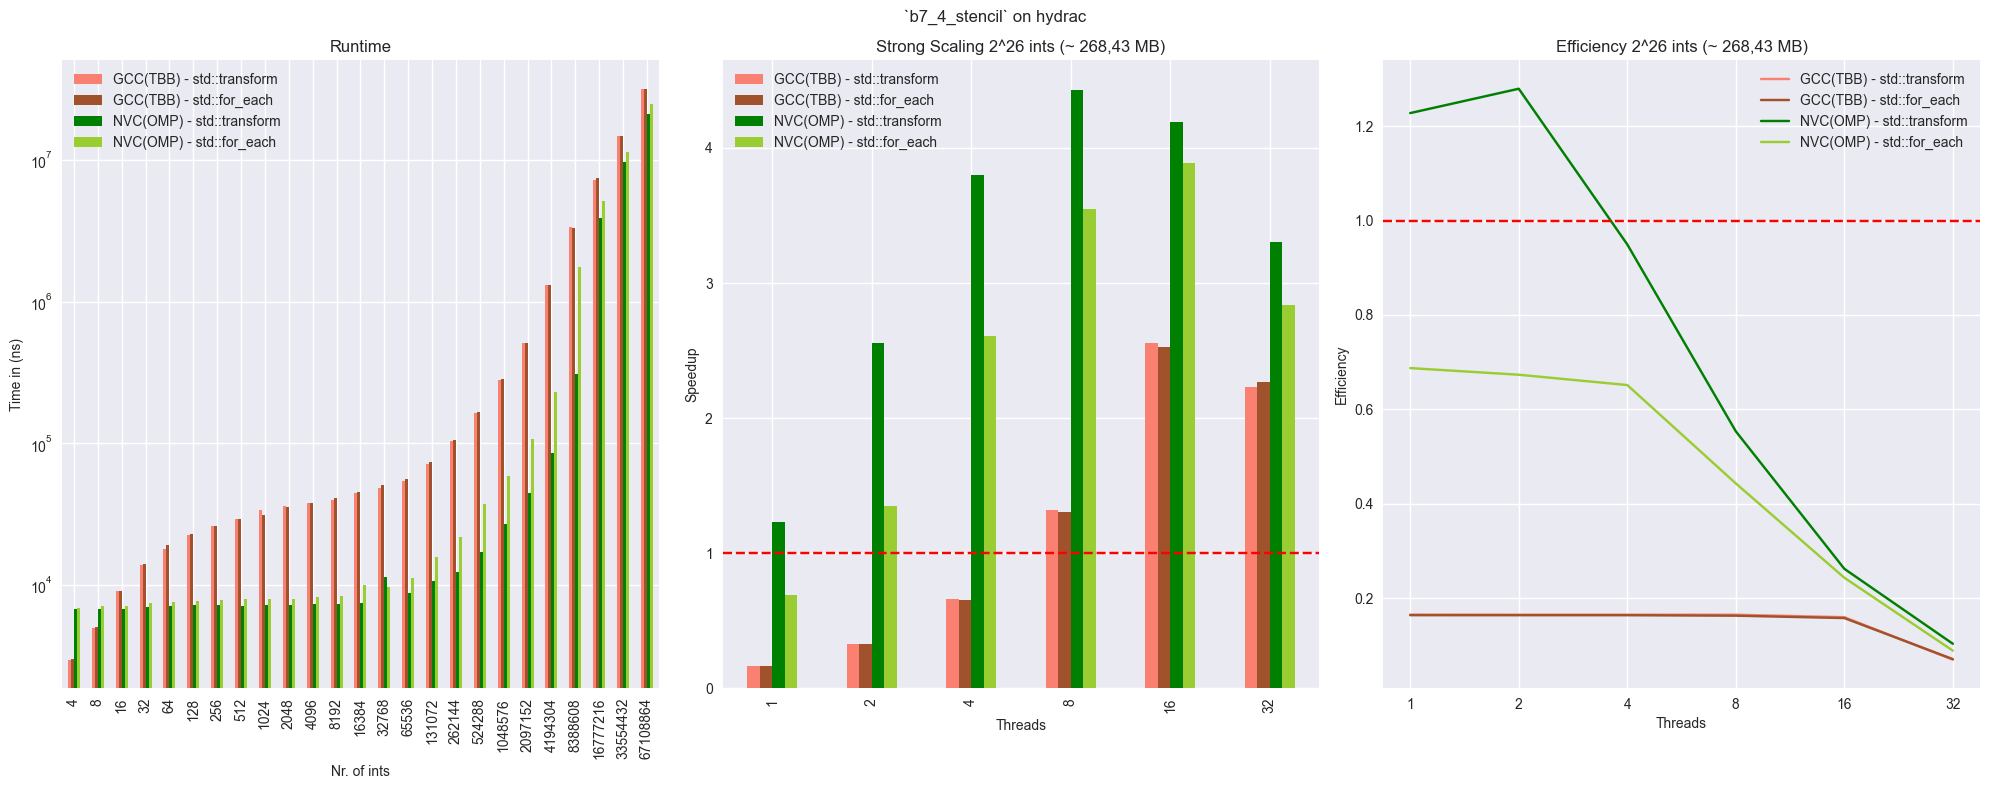

In [80]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_4_stencil_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_4_stencil_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')

#ax_2.set_ylim(0,2.5)



# plot efficiency
ax_3 = b7_4_stencil_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_4_stencil` on {device_name}")

fig.tight_layout()

plot(f"`b7_4_stencil` {device_name}")

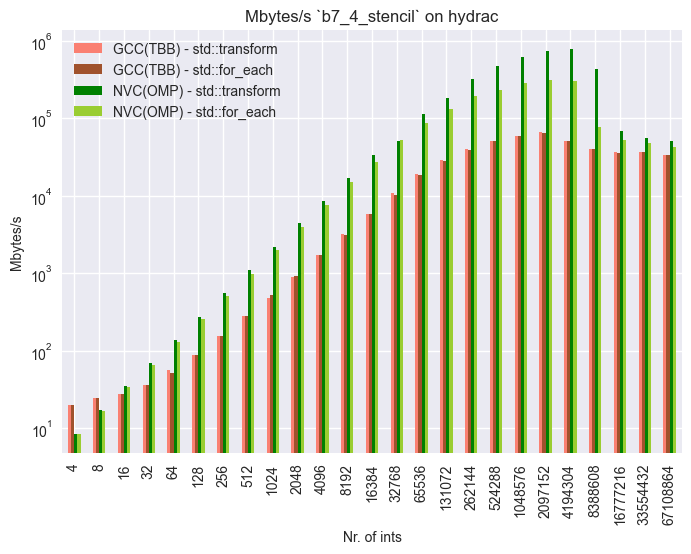

In [81]:

# mbytes graph

b7_4_stencil_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_4_stencil` on {device_name}')


plot(f'`b7_4_stencil` Mbytes_s on {device_name}')

## `b7_5` - Scalar Transform 

In [82]:
benchmark_names = [
    ("b7_5_scalar_transform_number",'std::transform'),
    ("b7_5_scalar_for_each",'std::for_each')
]

strong_scale_base = 'b7_5_scalar_transform_number'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [83]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_5_scalar_transform_time_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_time_merged = pd.merge(b7_5_scalar_transform_time_merged,data[i], on='n')

b7_5_scalar_transform_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,3796.17,4,3777.57,6765.86,6900.45
1,5746.21,8,5909.61,7083.24,6931.82
2,9597.15,16,9734.72,7127.34,7329.34
3,14276.90,32,14197.30,7362.73,7777.24
4,17550.70,64,17778.60,7228.50,7483.70
5,22607.40,128,22867.90,7182.44,7415.67
6,25802.80,256,25580.10,7164.92,7460.33
7,29786.20,512,29886.80,7217.14,7387.08
8,32812.10,1024,33719.60,7277.01,7340.82
9,35331.50,2048,36634.10,7385.58,7506.43


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [84]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_5_scalar_transform_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_strong_scaling_merged = pd.merge(b7_5_scalar_transform_strong_scaling_merged,data[i], on='threads')


b7_5_scalar_transform_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.997272,0.598037,0.644699,0.324602
1,2,1.749023,1.181646,1.253905,0.647465
2,4,3.149544,2.091191,2.181821,1.292612
3,8,4.052936,2.757136,3.726722,2.402821
4,16,3.682880,3.125138,4.592124,3.318834
5,32,3.224419,2.195980,3.367538,2.602894


In [85]:
## efficiency graph

b7_5_scalar_transform_efficiency = b7_5_scalar_transform_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] = b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] / b7_5_scalar_transform_efficiency['threads']

b7_5_scalar_transform_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.997272,0.598037,0.644699,0.324602
1,2,0.874511,0.590823,0.626952,0.323733
2,4,0.787386,0.522798,0.545455,0.323153
3,8,0.506617,0.344642,0.465840,0.300353
4,16,0.230180,0.195321,0.287008,0.207427
5,32,0.100763,0.068624,0.105236,0.081340


### Mbytes/s

In [86]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_5_scalar_transform_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_bytes_merged = pd.merge(b7_5_scalar_transform_bytes_merged,data[i], on='n')

b7_5_scalar_transform_bytes_merged

,n,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4,8.32634,8.39265,4.67635,4.54319
1,8,10.98270,10.70340,8.84043,9.04487
2,16,13.19170,12.97430,17.57620,17.00900
3,32,17.77220,17.80080,33.93610,31.28620
4,64,28.95340,28.47770,69.14480,64.92220
5,128,44.99740,44.37600,139.34100,132.10300
6,256,78.93910,79.48190,279.07700,260.46600
7,512,136.83200,136.30900,554.09200,525.85400
8,1024,248.63000,241.72400,1099.01000,1061.90000
9,2048,462.07500,445.24100,2169.67000,2078.97000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_27218/3247401511.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


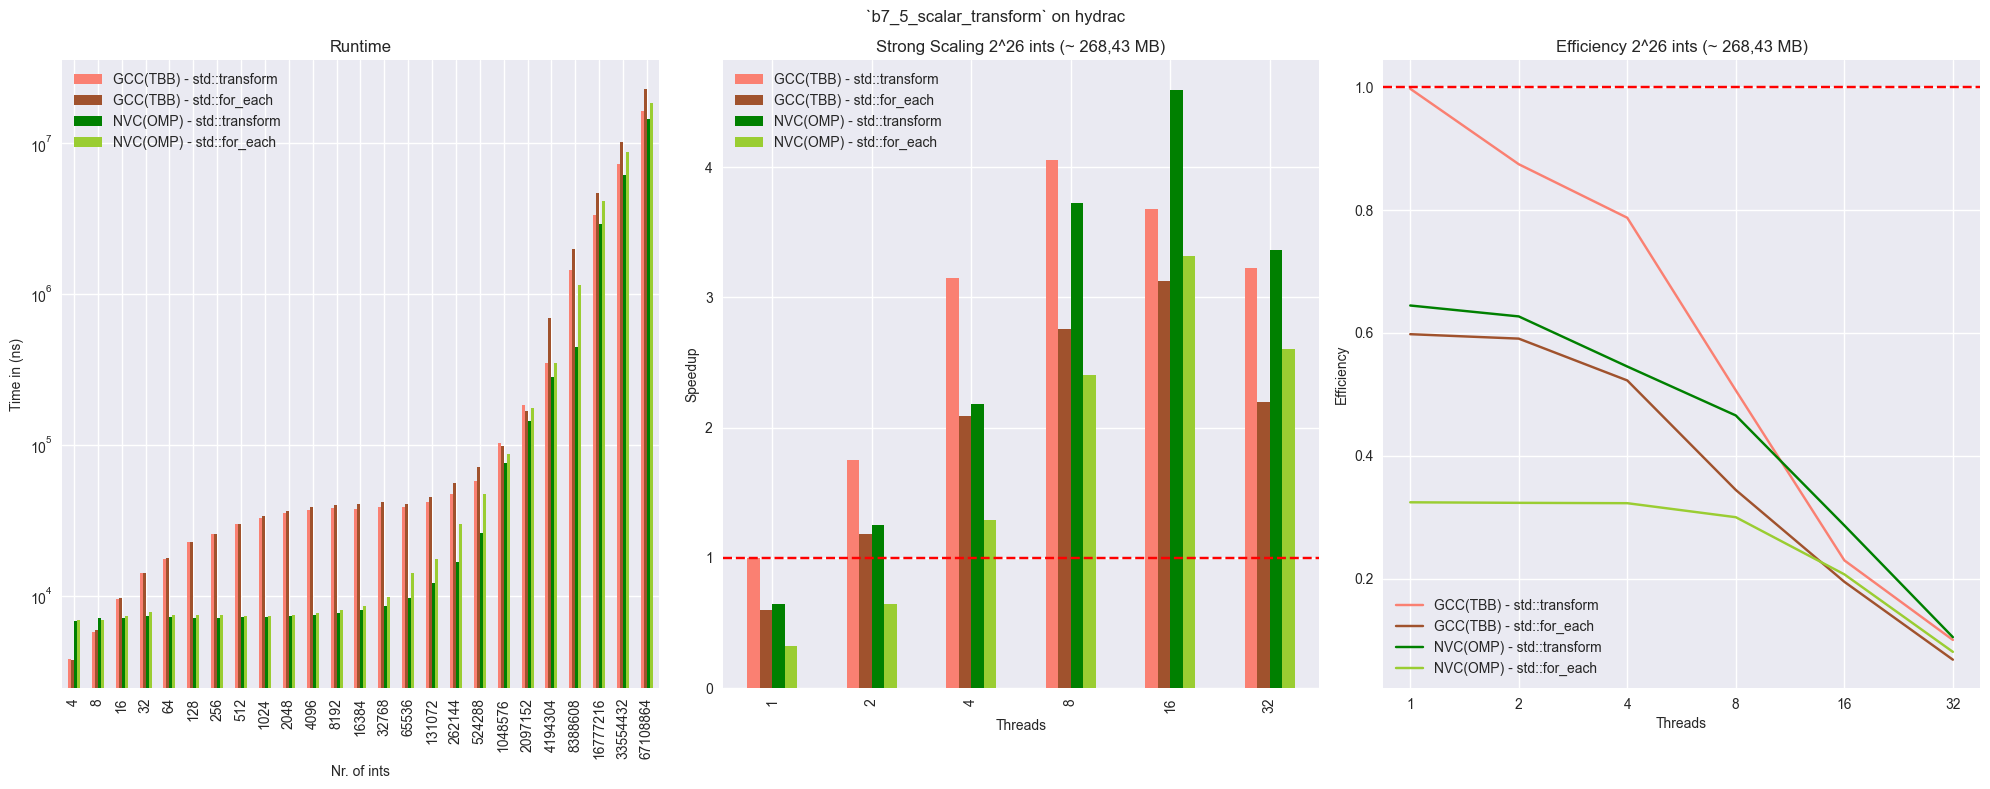

In [87]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_5_scalar_transform_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_5_scalar_transform_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = b7_5_scalar_transform_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_5_scalar_transform` on {device_name}")

fig.tight_layout()

plot(f"`b7_5_scalar_transform` {device_name}")

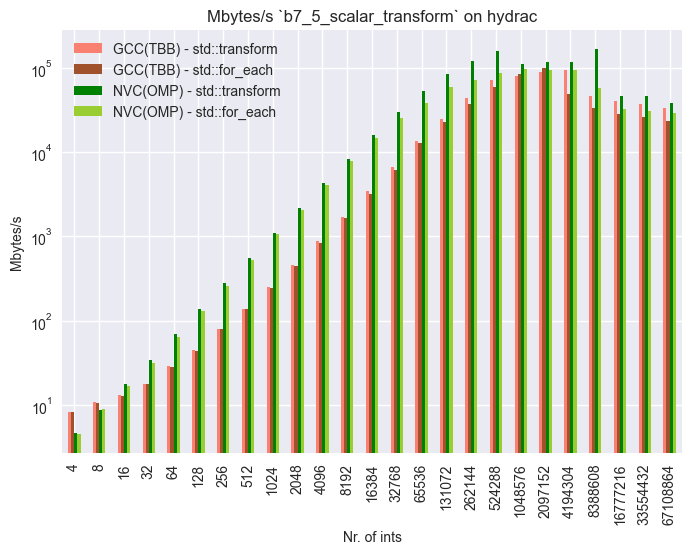

In [88]:

# mbytes graph

b7_5_scalar_transform_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_5_scalar_transform` on {device_name}')


plot(f'`b7_5_scalar_transform` Mbytes_s on {device_name}')

## `b7_6` - Serial vs direct call

In [89]:
benchmark_names = [
    ("b7_6_transform_reduce",'std::transform_reduce'),
    ("b7_6_serial_transform_reduce",'serial')
]

strong_scale_base = 'b7_6_transform_reduce'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [90]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_6_transform_reduce_vs_serial_time_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_time_merged = pd.merge(b7_6_transform_reduce_vs_serial_time_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_time_merged

,GCC(TBB) - std::transform_reduce,n,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,3010.34,4,5.139690e+03,12142.9,16830.1
1,3900.73,8,8.366900e+03,12515.6,17426.2
2,5870.85,16,1.459540e+04,12833.5,19015.2
3,9487.32,32,2.321070e+04,14208.5,19344.6
4,14162.20,64,3.110280e+04,14089.0,19769.5
5,18030.40,128,3.918370e+04,13597.0,19400.1
6,22575.80,256,4.780520e+04,13638.5,19475.4
7,27238.10,512,5.655230e+04,13817.4,19661.1
8,28986.00,1024,6.342970e+04,13871.6,19614.8
9,33147.60,2048,6.972230e+04,14053.9,21991.5


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [91]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_6_transform_reduce_vs_serial_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_strong_scaling_merged = pd.merge(b7_6_transform_reduce_vs_serial_strong_scaling_merged,data[i], on='threads')


b7_6_transform_reduce_vs_serial_strong_scaling_merged

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,0.978392,0.416046,1.407441,0.389466
1,2,1.969260,0.589621,2.535328,0.567592
2,4,3.671797,0.780278,5.016255,0.749680
3,8,5.516410,0.871430,6.765390,0.851702
4,16,8.288579,0.891659,11.297311,0.890715
5,32,7.500601,0.827325,7.716363,0.811257


In [92]:
## efficiency graph

b7_6_transform_reduce_vs_serial_efficiency = b7_6_transform_reduce_vs_serial_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] = b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] / b7_6_transform_reduce_vs_serial_efficiency['threads']

b7_6_transform_reduce_vs_serial_efficiency

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,0.978392,0.416046,1.407441,0.389466
1,2,0.984630,0.294810,1.267664,0.283796
2,4,0.917949,0.195070,1.254064,0.187420
3,8,0.689551,0.108929,0.845674,0.106463
4,16,0.518036,0.055729,0.706082,0.055670
5,32,0.234394,0.025854,0.241136,0.025352


### Mbytes/s   

In [93]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_6_transform_reduce_vs_serial_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_bytes_merged = pd.merge(b7_6_transform_reduce_vs_serial_bytes_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_bytes_merged

,n,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,4,10.5390,18.5843,2.61186,5.69586
1,8,16.2976,22.8156,5.06289,11.02440
2,16,21.5367,26.1529,9.88003,20.14700
3,32,26.7293,32.9070,17.84040,39.54180
4,64,35.8460,49.1532,35.90080,77.44480
5,128,56.3408,78.1324,74.25120,157.90500
6,256,90.0873,128.1550,147.60900,314.36700
7,512,149.4320,216.8960,292.60400,623.55800
8,1024,281.1560,386.7780,583.69800,1249.56000
9,2048,491.8870,704.1620,1153.72000,2229.97000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_27218/182734503.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


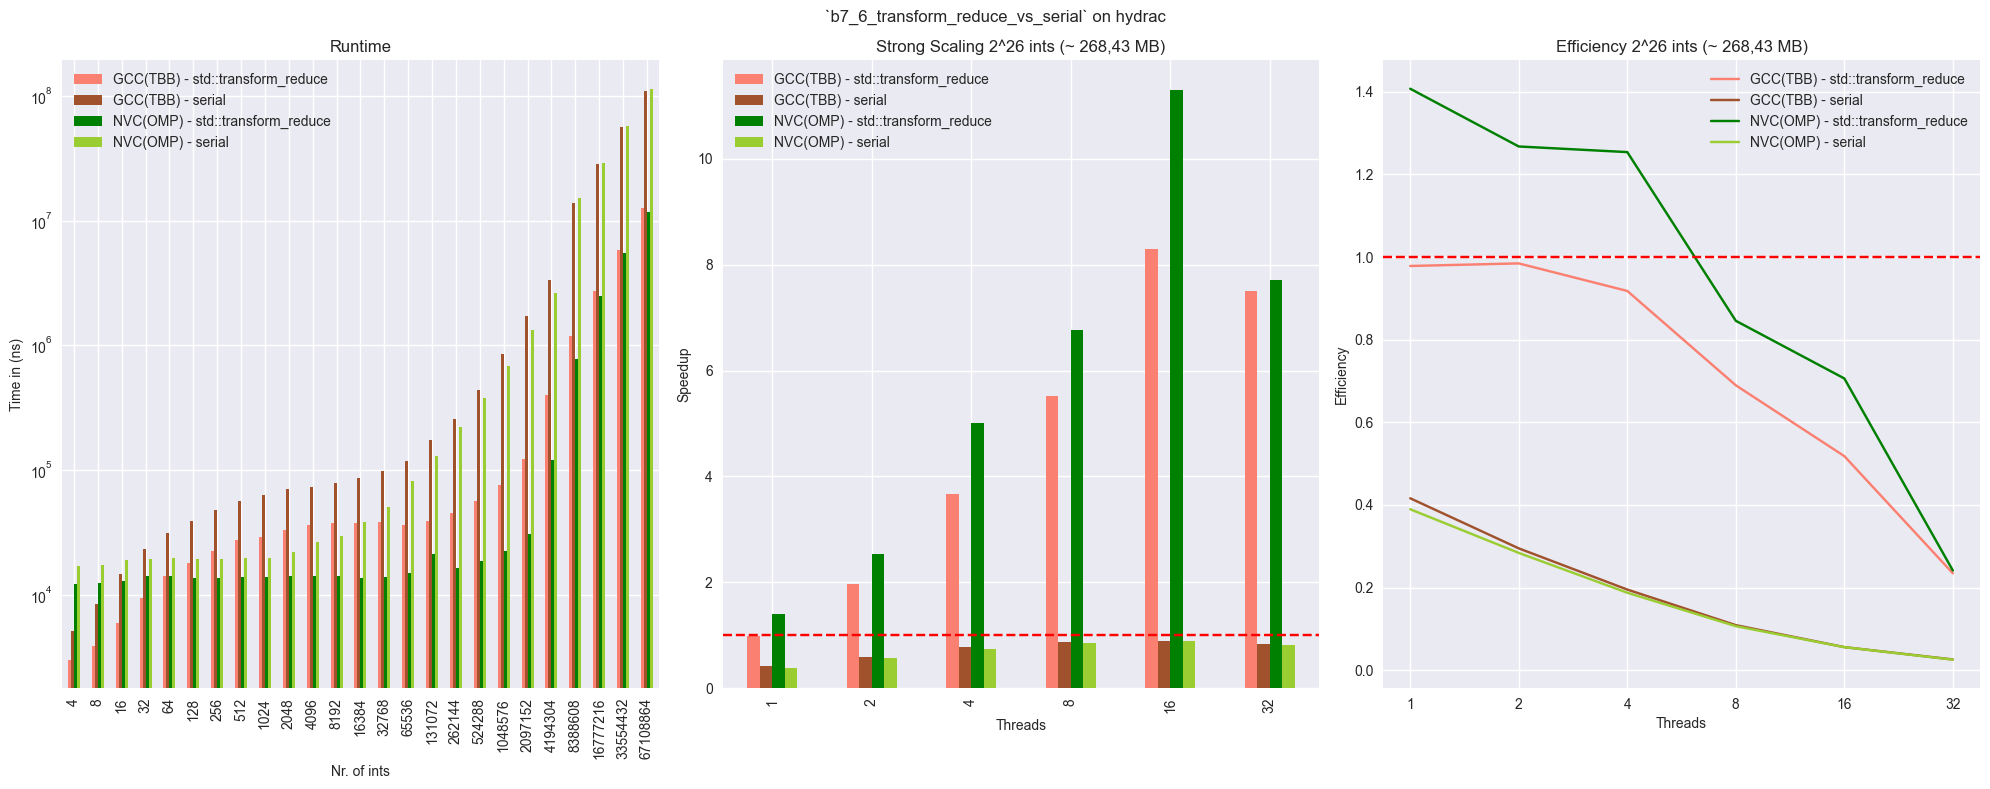

In [94]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_6_transform_reduce_vs_serial_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_6_transform_reduce_vs_serial_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_6_transform_reduce_vs_serial_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_6_transform_reduce_vs_serial` on {device_name}")

fig.tight_layout()

plot(f"`b7_6_transform_reduce_vs_serial` {device_name}")

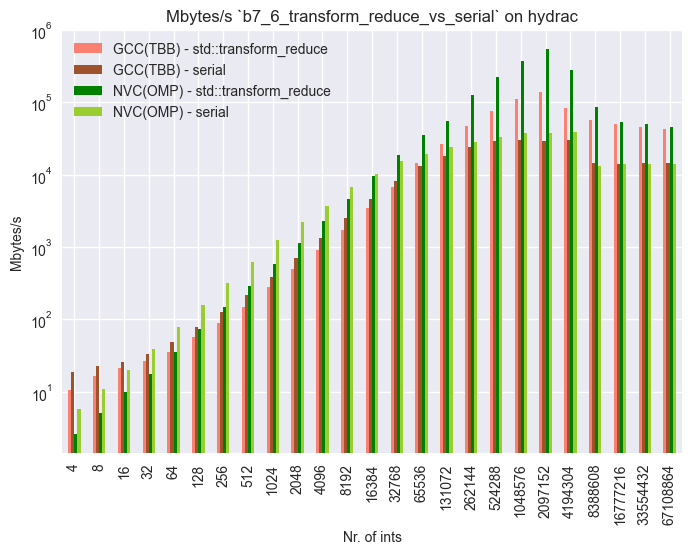

In [95]:
# mbytes graph

b7_6_transform_reduce_vs_serial_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_6_transform_reduce_vs_serial` on {device_name}')


plot(f'`b7_6_transform_reduce_vs_serial` Mbytes_s on {device_name}')

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

Runtime

In [96]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b7_1_copy',b7_1_time_merged, [' - std::copy', ' - std::foreach']),
    
    ('b7_2_all_of_all_true',b7_2_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_first_false',b7_2_first_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_last_false',b7_2_last_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_auto_false',b7_2_auto_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),


    ('b7_3_count_if_all_hit',b7_3_all_hit_time_merged, [' - std::count_if', ' - std::transform_reduce']),
    ('b7_3_count_if_half_hit',b7_3_half_hit_time_merged, [' - std::count_if', ' - std::transform_reduce']),
    ('b7_3_count_if_orders_struct',b7_3_orders_struct_time_merged, [' - std::count_if', ' - std::transform_reduce']),

    
    ('b7_4_stencil_transform',b7_4_stencil_time_merged, [' - std::transform', ' - std::for_each']),


    ('b7_5_scalar_transform',b7_5_scalar_transform_time_merged, [' - std::transform', ' - std::for_each']),


    ('b7_6_transform_reduce',b7_6_transform_reduce_vs_serial_time_merged, [' - std::transform_reduce', ' - serial']),
]


for root_display_name, data_source, suffixes in data_fields:

    for suffix in suffixes:
        entry_dict = {
            'name': [root_display_name + suffix],
        }

        vals = []

        # getting the data from the source for each compiler
        for comp in compilers:
            current_val = int(data_source.iloc[-1][comp + suffix])
            entry_dict[comp] = [current_val]

            vals.append(current_val)

        entry_dict['PP'] = calc_pp(vals)

        other_df = pd.DataFrame.from_dict(entry_dict)
        pp_df = pd.concat([pp_df,other_df],ignore_index=True)



pp_df['Percentage'] = pp_df['PP']

pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')


pp_df_styled = pp_df.style.format({'Percentage': "{:.2%}"})
pp_df_styled

,name,GCC(TBB),NVC(OMP),PP,Percentage,INTERPRET
0,b7_1_copy - std::copy,11881700,18142400,0.791478,79.15%,BAD
1,b7_1_copy - std::foreach,46990800,18252800,0.559528,55.95%,BAD
2,b7_2_all_of_all_true - std::all_of,3926840,6601420,0.745962,74.60%,BAD
3,b7_2_all_of_all_true - std::transform_reduce,3918650,3443750,0.935497,93.55%,GOOD
4,b7_2_all_of_first_false - std::all_of,9310,117168,0.147219,14.72%,BAD
5,b7_2_all_of_first_false - std::transform_reduce,3977150,4043570,0.991719,99.17%,GOOD
6,b7_2_all_of_last_false - std::all_of,3426460,6672990,0.678544,67.85%,BAD
7,b7_2_all_of_last_false - std::transform_reduce,3939650,3778740,0.979152,97.92%,GOOD
8,b7_2_all_of_auto_false - std::all_of,7292,32039,0.370802,37.08%,BAD
9,b7_2_all_of_auto_false - std::transform_reduce,555806,13994,0.049119,4.91%,BAD


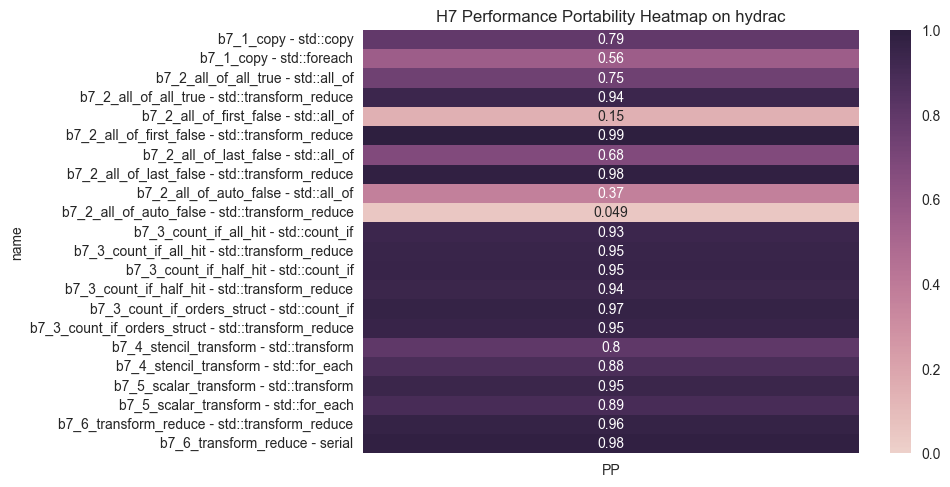

In [97]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','Percentage','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H7 Performance Portability Heatmap on {device_name}')

plot(f'H7 Performance Portability Heatmap on {device_name}')


## Findings for H7

### XXX

### General


### GPU Findings


### Hypothesis Findings


